# Oxygen Measurement Accuracy and Sensor Drift Across Missions


**Research Question:**

*How do oxygen concentration measurements from gliders compare to ship-based measurements in the Gulf of Saint Lawrence, and what role does sensor drift across different glider models and missions play in measurement discrepancies?*

In [1]:
# Silent warnings
import warnings
warnings.filterwarnings("ignore")

# Core
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf


# Data
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('darkgrid')
plt.style.use('ggplot')

import os

## Load and Process Data

In [2]:

# Load Glider Data
# Define the folder path
folder_path = r'C:\Users\linhv\OneDrive - York University\Math 2130\Ship Gliders data'

# Dictionary to store dataframes
gliderDf = {}

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Process only csv files
        # Extract the name before the second "_"
        key_name = file_name.split('_')[0] + "_" + file_name.split('_')[1] + "_" + file_name.split('_')[2]
        # Read the file into a dataframe
        file_path = os.path.join(folder_path, file_name)
        gliderDf[key_name] = pd.read_csv(file_path)

# Load Ship Data
shipDf = pd.read_csv(r'C:\Users\linhv\OneDrive - York University\Math 2130\ship_data_cleaned.csv')

**Ship Data Cleaning for Matching**

In [3]:


# Drop unnecessary columns for matching and assign the result to ship_df
ship_df = shipDf[['Latitude', 'Longitude', 'Temp', 'Salinity', 'best_Oxygen', 'Depth', 'Density']]

# Rename the column
ship_df.rename(columns={'best_Oxygen': 'Oxygen'}, inplace=True)



**Functions for Matching**

In [4]:
from sklearn.neighbors import NearestNeighbors

def KNN_Matching(glider_df, ship_df):
    """
    Match glider data to the nearest ship-based measurements using KNN 
    based on Depth, Longitude, Latitude, and Temperature.
    
    Returns:
        flat_distances: Flattened array of KNN distances
        indices: Indices of nearest neighbors from ship_df
    """
    # Extract features
    glider_features = glider_df[['latitude','longitude',
                                  'depth', 
                                  'temperature', 
                                ]].values

    ship_features = ship_df[['Latitude', 'Longitude', 
                             'Depth', 
                            'Temp']].values

    # Fit KNN
    knn = NearestNeighbors(n_neighbors=1, metric='euclidean')
    knn.fit(ship_features)

    # Get distances and indices
    distances, indices = knn.kneighbors(glider_features)
    flat_distances = distances.flatten()
    
    return flat_distances, indices

def plot_distance_curve(glider_df, ship_df): 
    """
    Plot a sorted KNN distance curve to help determine matching threshold.

    """
    flat_distances, _ = KNN_Matching(glider_df, ship_df)  # <- Store returned values
    sorted_distances = np.sort(flat_distances)

    # Plot
    plt.figure(figsize=(8, 4))
    plt.plot(sorted_distances, marker='.', linestyle='-', color='teal')
    plt.title('KNN Distance Curve (Elbow Method)')
    plt.xlabel('Sorted Sample Index')
    plt.ylabel('Distance')
    plt.grid(True)
    plt.show()

# Create a function to take a threshold and return the matched data
def knn_get_matched_df(glider_df, ship_df, threshold):
    """
    Match glider data to the nearest ship-based measurements using KNN based on Depth, Longitude, Latitude, and Temperature.
    Returns matched dataframes based on a distance threshold.
    """
    flat_distances, indices = KNN_Matching(glider_df, ship_df)  # <- Store returned values 

    # Threshold filtering
    valid_matches = flat_distances < threshold

    # Get matched glider and ship data
    matched_glider = glider_df[valid_matches].reset_index(drop=True)
    matched_ship = ship_df.iloc[indices.flatten()[valid_matches]].reset_index(drop=True)

    # Optimize memory by converting object columns to category
    for col in matched_glider.select_dtypes(include='object').columns:
        matched_glider[col] = matched_glider[col].astype('category')
    for col in matched_ship.select_dtypes(include='object').columns:
        matched_ship[col] = matched_ship[col].astype('category')

    # Merge and return the matched data
    matched_df = pd.concat([matched_glider, matched_ship.add_suffix('_ship')], axis=1)
    return matched_df

**Potential Limitation of our Matching**

We choose to match by environmental similarities (same region, depth, and temperature) rather than by time because gliders and ship data was collected in different time periods. As a result, our model might capture both temporarial variation and sensor drift.

However, we believe that matching based on environmental similarities allows us to effectively controlling for regional and environmental factors that influence oxygen levels and ensure that the differences are less likely due to uncaptured variations.

**Spatial Overlap Check**

*Analyze the spatial coverage of each glider mission and select those that align with the ship-based sampling locations for more accurate match.*

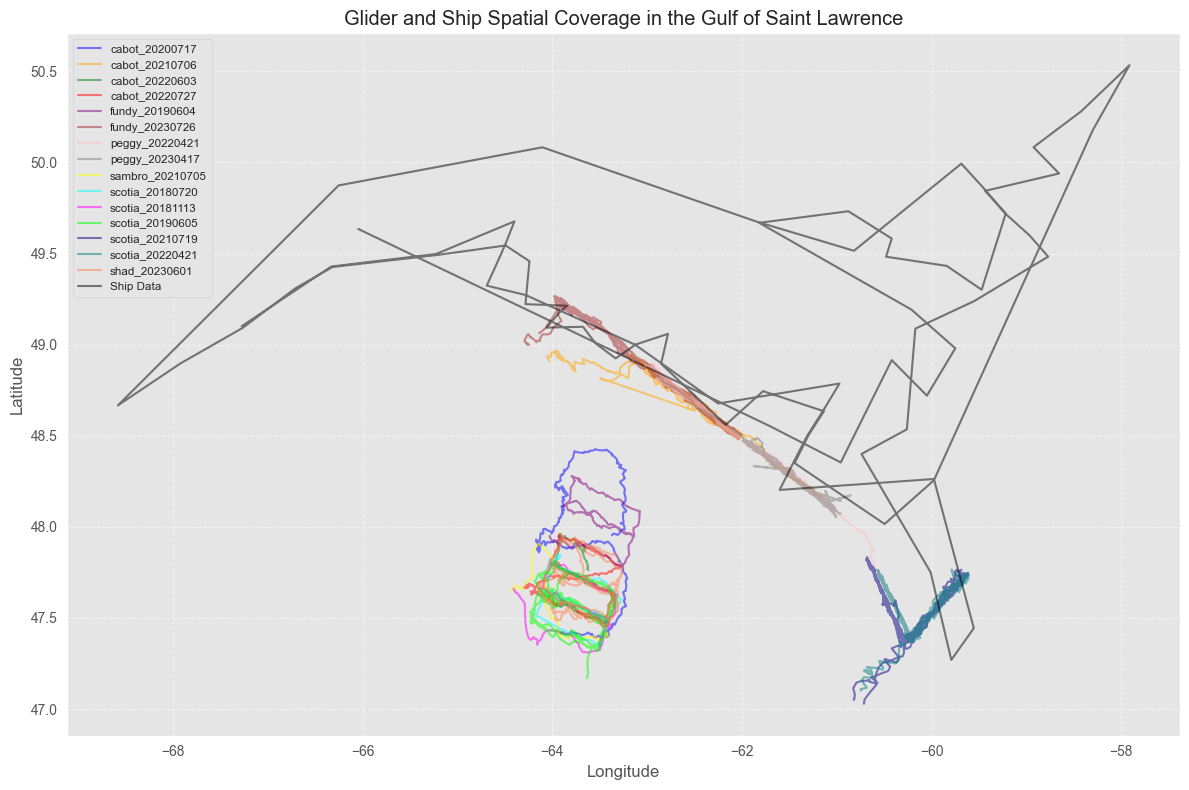

In [5]:

color = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'yellow', 'cyan', 'magenta', 'lime', 'navy', 'teal', 'coral']

plt.figure(figsize=(12, 8))
for (name, df), x in zip(gliderDf.items(), color):
    label = name.split('_')[1] + "_" + name.split('_')[2].split('.')[0]
    plt.plot(df['longitude'], df['latitude'], color=x, label=label, alpha=0.5)
plt.plot(shipDf['Longitude'], shipDf['Latitude'], color='black', alpha=0.5, label='Ship Data')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Glider and Ship Spatial Coverage in the Gulf of Saint Lawrence")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='best', fontsize='small', title='')
plt.tight_layout()
plt.show()

Of the 15 glider missions, only 4 of them showed significant spatial overlap with ship-based data. We retained these and exclude glider datasets outside the ship survey region due to insufficient geographic coverage which will lead to difference in measurements and poor matching.

**Define Distance Curve and Threshold**

*Generate a distance curve to visualize and determine a reasonable threshold for matching glider and ship observations. This threshold will help filter out bad data (outliers) and ensured only the most comparable data points were used.*

In [8]:
# Rename column names for easier analysis
for name, df in gliderDf.items():
    if name in valid_df:
        df.rename(columns={
            'sea_water_temperature': 'temperature',
            'sea_water_practical_salinity': 'salinity',
            'sea_water_density': 'density',
            'micromoles_of_oxygen_per_unit_mass_in_sea_water': 'oxygen',
            'time': 'datetime'
        }, inplace=True)

Distance curve for cleaned_cabot_20210706.csv


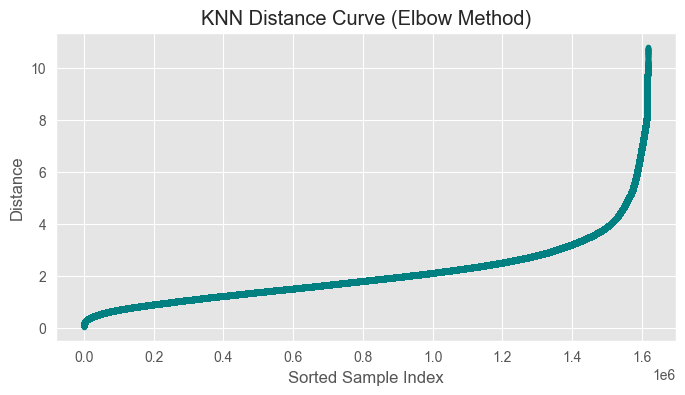

Distance curve for cleaned_fundy_20230726.csv


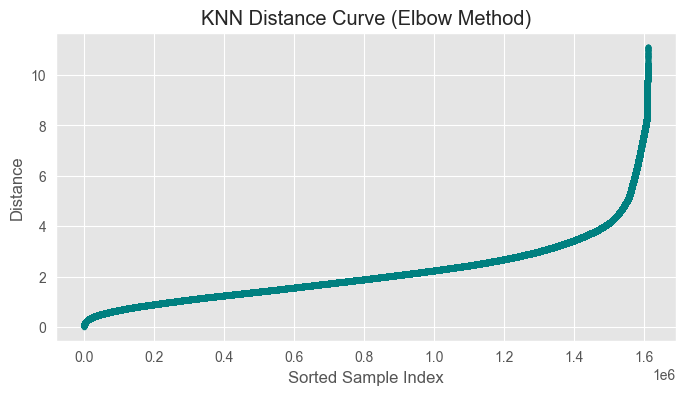

Distance curve for cleaned_peggy_20220421.csv


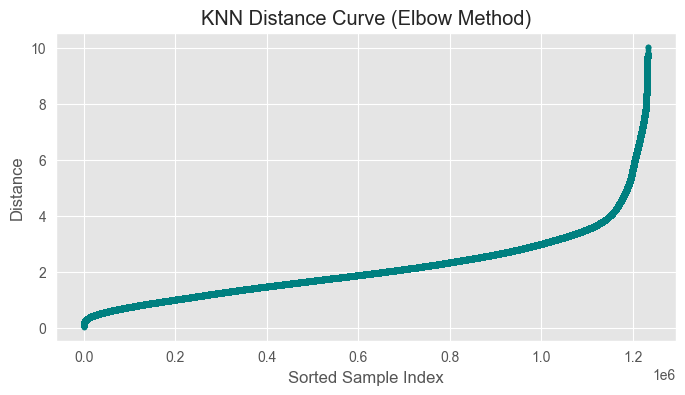

Distance curve for cleaned_peggy_20230417.csv


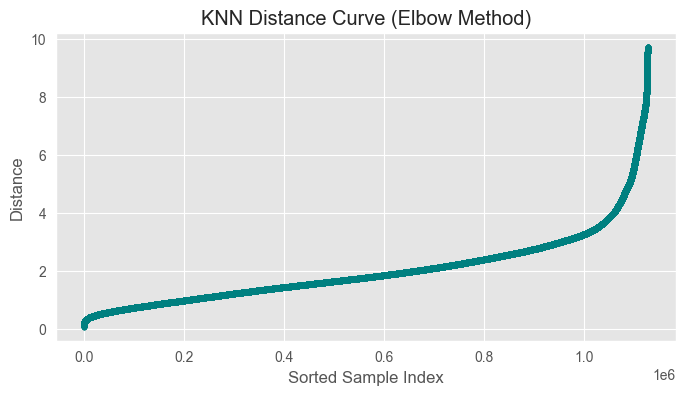

In [9]:
valid_df = ['cleaned_peggy_20230417.csv','cleaned_peggy_20220421.csv', 'cleaned_fundy_20230726.csv', 'cleaned_cabot_20210706.csv']


for name, df in gliderDf.items():
    if name in valid_df:
        print(f'Distance curve for {name}')
        #call the function to get the distance curve
        plot_distance_curve(df, ship_df)

1.8 seems to be a good threshold that can be used to cut off bad data based on the distance curves generated.

## Visualize the matched data for each glider dataset


In [10]:

#define the glider and ship variables to plot
glider_vars =['latitude','longitude','depth', 
                'oxygen', 
                'temperature', 
                'salinity', 
                'density']

ship_vars = ['Latitude_ship', 'Longitude_ship', 'Depth_ship', 
             'Oxygen_ship', 
             'Temp_ship', 
             'Salinity_ship', 
             'Density_ship']


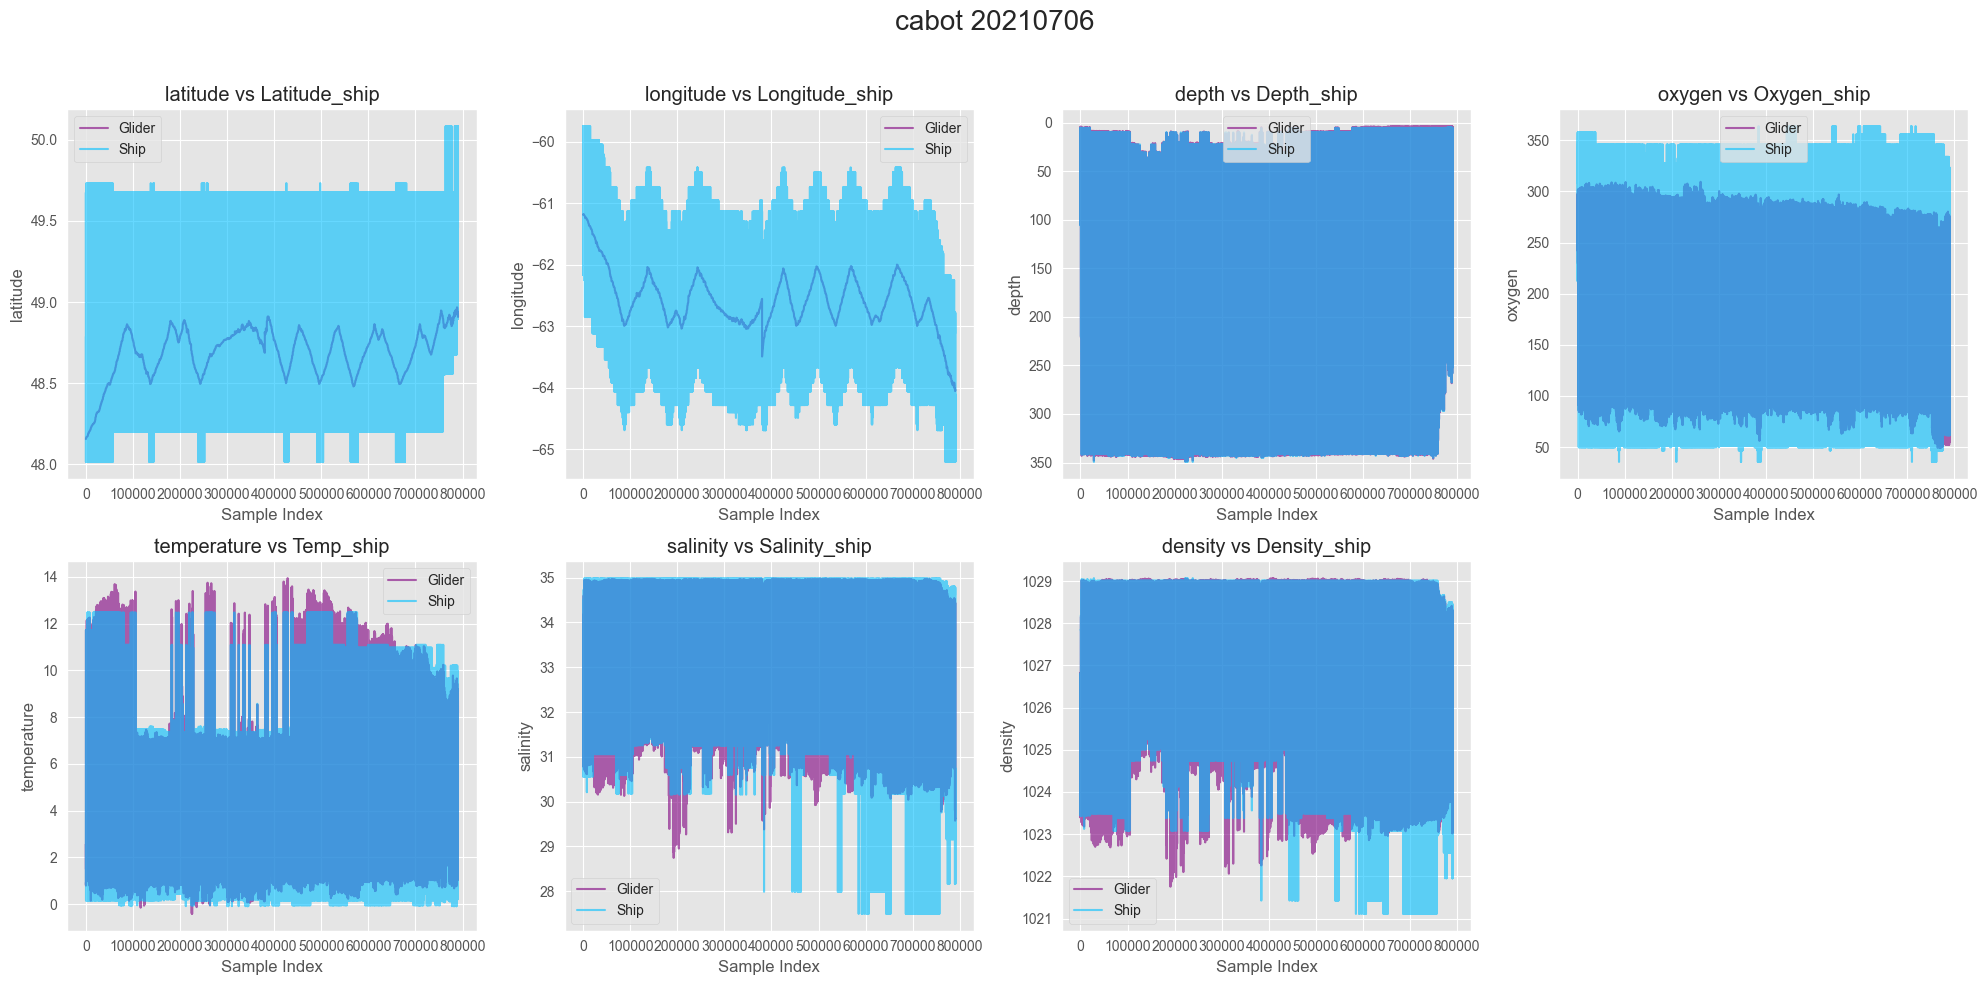

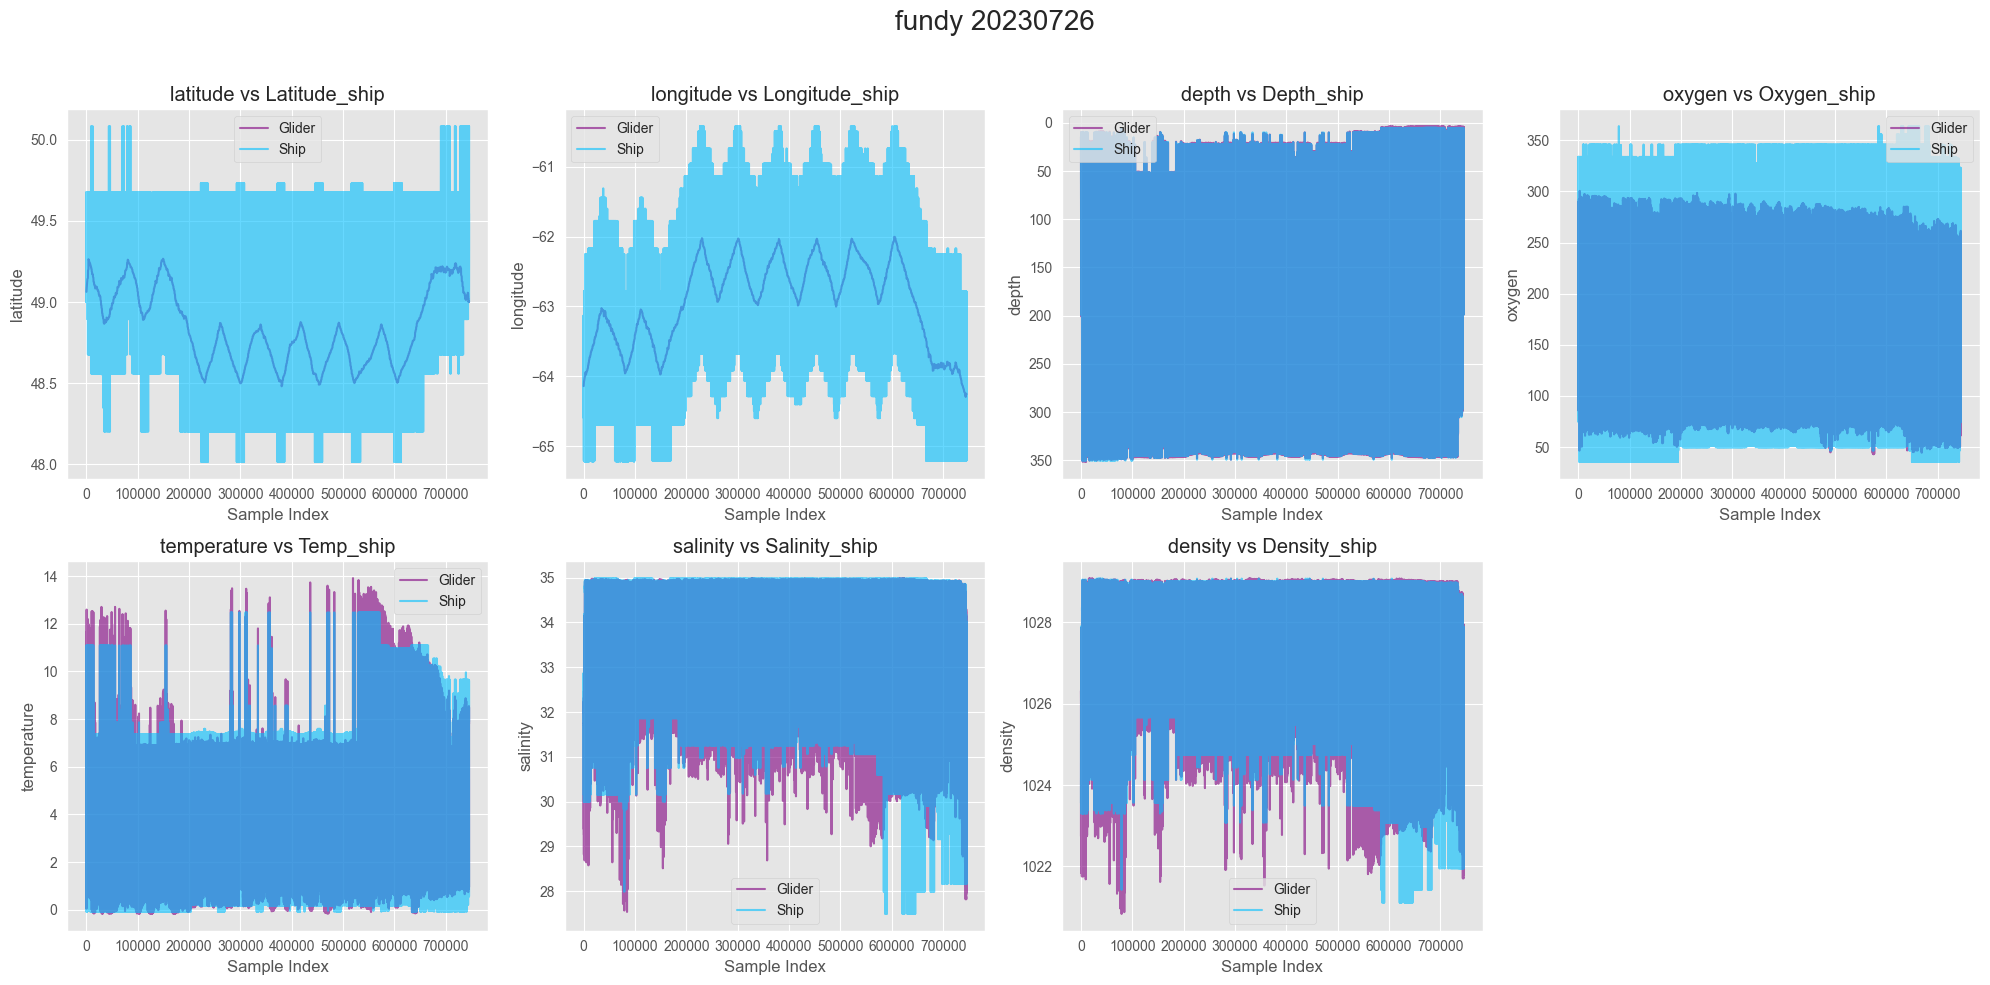

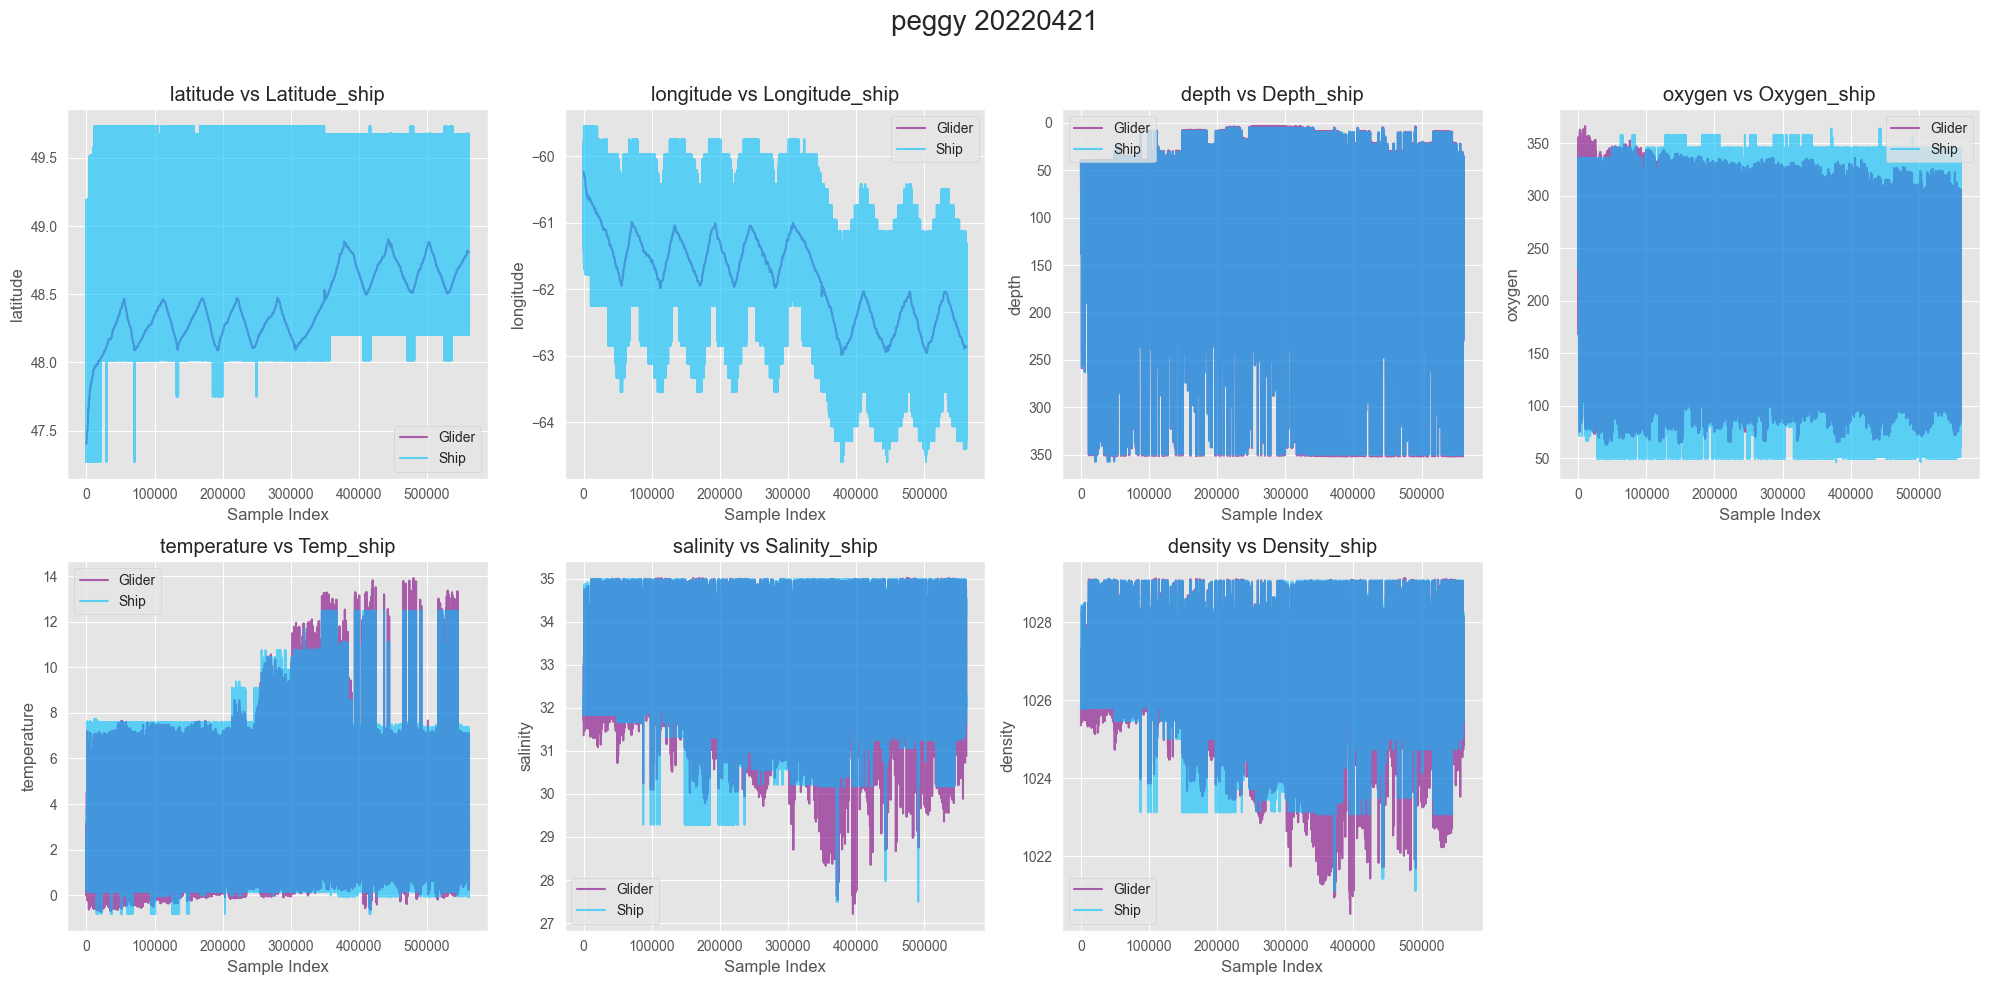

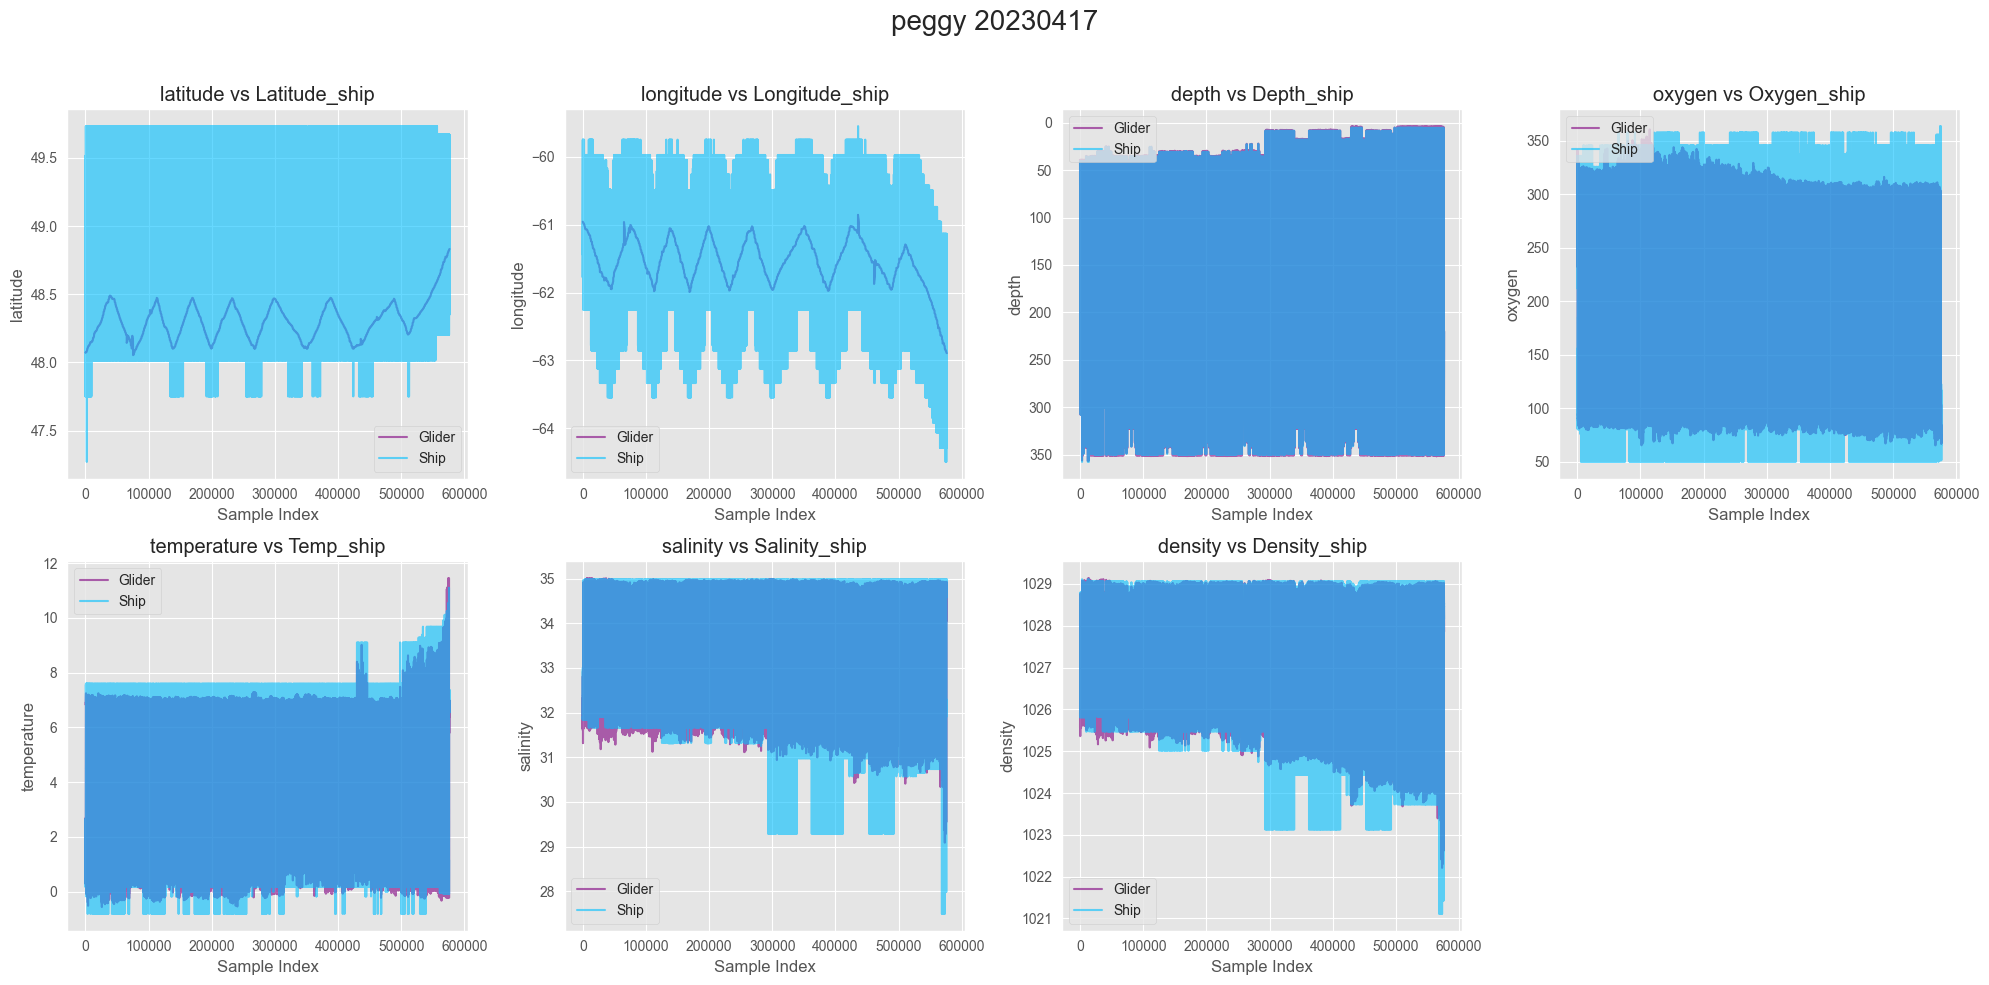

In [11]:
for name, df in gliderDf.items():
    if name in valid_df:
        matched_df = knn_get_matched_df(df, ship_df, threshold=1.8).reset_index()
        title = name.split('_')[1] + ' ' + name.split('_')[2].split('.')[0]

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f'{title}', fontsize=20)

        for i, (g_var, s_var) in enumerate(zip(glider_vars, ship_vars)):
            ax = axes[i // 4, i % 4]
            sns.lineplot(data=matched_df, x='index', y=g_var, color='purple', label='Glider', ax=ax, alpha=0.6)
            sns.lineplot(data=matched_df, x='index', y=s_var, color='deepskyblue', label='Ship', ax=ax, alpha=0.6)

            ax.set_title(f'{g_var} vs {s_var}')
            ax.set_xlabel('Sample Index')
            ax.set_ylabel(g_var.split('_')[0])  # cleaner label

            if 'depth' in g_var.lower():
                ax.invert_yaxis()

            ax.legend()

        # Turn off the 8th (unused) subplot if 7 variables
        if len(glider_vars) < 8:
            axes[1, 3].axis('off')

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()


Longitude and Latitude of Gliders and ship after match across glider missions seem to be off by at most roughly 1°, meaning they are off by about 111km. However, this is not a concern because we will use this data to look at regional patterns (stratification, large-scale trends). In addition, other variables (temperature , depth, salinity and density) match quite closely, which is a great sign.

**Combine Valid Matched Dataset**

In [12]:
for name, df in gliderDf.items():
    if name in valid_df:
        matched_df = knn_get_matched_df(df, ship_df, threshold=1.8)
        matched_df['datetime'] = pd.to_datetime(matched_df['datetime'], format='%Y-%m-%d %H:%M:%S')
        id = name.split('_')[1]+ ' ' + name.split('_')[2].split('.')[0]
        matched_df['mission_id'] = id  # Add mission identifier
        #concatenate the all valid df into one df
        if 'combined_df' in locals():
            combined_df = pd.concat([combined_df, matched_df])
        else:
            combined_df = matched_df
combined_df.reset_index(drop=True, inplace=True)


In [13]:
combined_df.reset_index(drop=True, inplace=True)

# Add temporal features
combined_df['month'] = combined_df['datetime'].dt.month
combined_df['year'] = combined_df['datetime'].dt.year

#plot the difference between glider and ship measurements over different variables over time
combined_df['delta_oxygen'] = combined_df['oxygen'] - combined_df['Oxygen_ship']
combined_df['delta_temp'] = combined_df['temperature'] - combined_df['Temp_ship']
combined_df['delta_salinity'] = combined_df['salinity'] - combined_df['Salinity_ship']
combined_df['delta_density'] = combined_df['density'] - combined_df['Density_ship']

combined_df['abs_delta_oxygen'] = combined_df['delta_oxygen'].abs()

## Sensor Drift Analysis


### Investigate Feature Difference Across Missions


*Distribution plot of Discrepancies*

In [14]:
# Get drift histogram across
def gliders_drift_hist(df, var):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Filter for the gliders of interest
    gliders = ['peggy 20220421', 'cabot 20210706', 'peggy 20230417', 'fundy 20230726']
    
    for i, glider in enumerate(gliders):
        glider_df = df[df["mission_id"] == glider]
        
        ax = axes[i // 2, i % 2]
        sns.histplot(data=glider_df, x=var, color='purple',
                      bins=30, ax=ax, alpha=0.5, kde=True)
        
        ax.set_title(f'{glider}')
        ax.set_xlabel(var)
        ax.set_ylabel("Frequency")
        
    plt.tight_layout()
    plt.show()

Oxygen Discrepancy Distribution


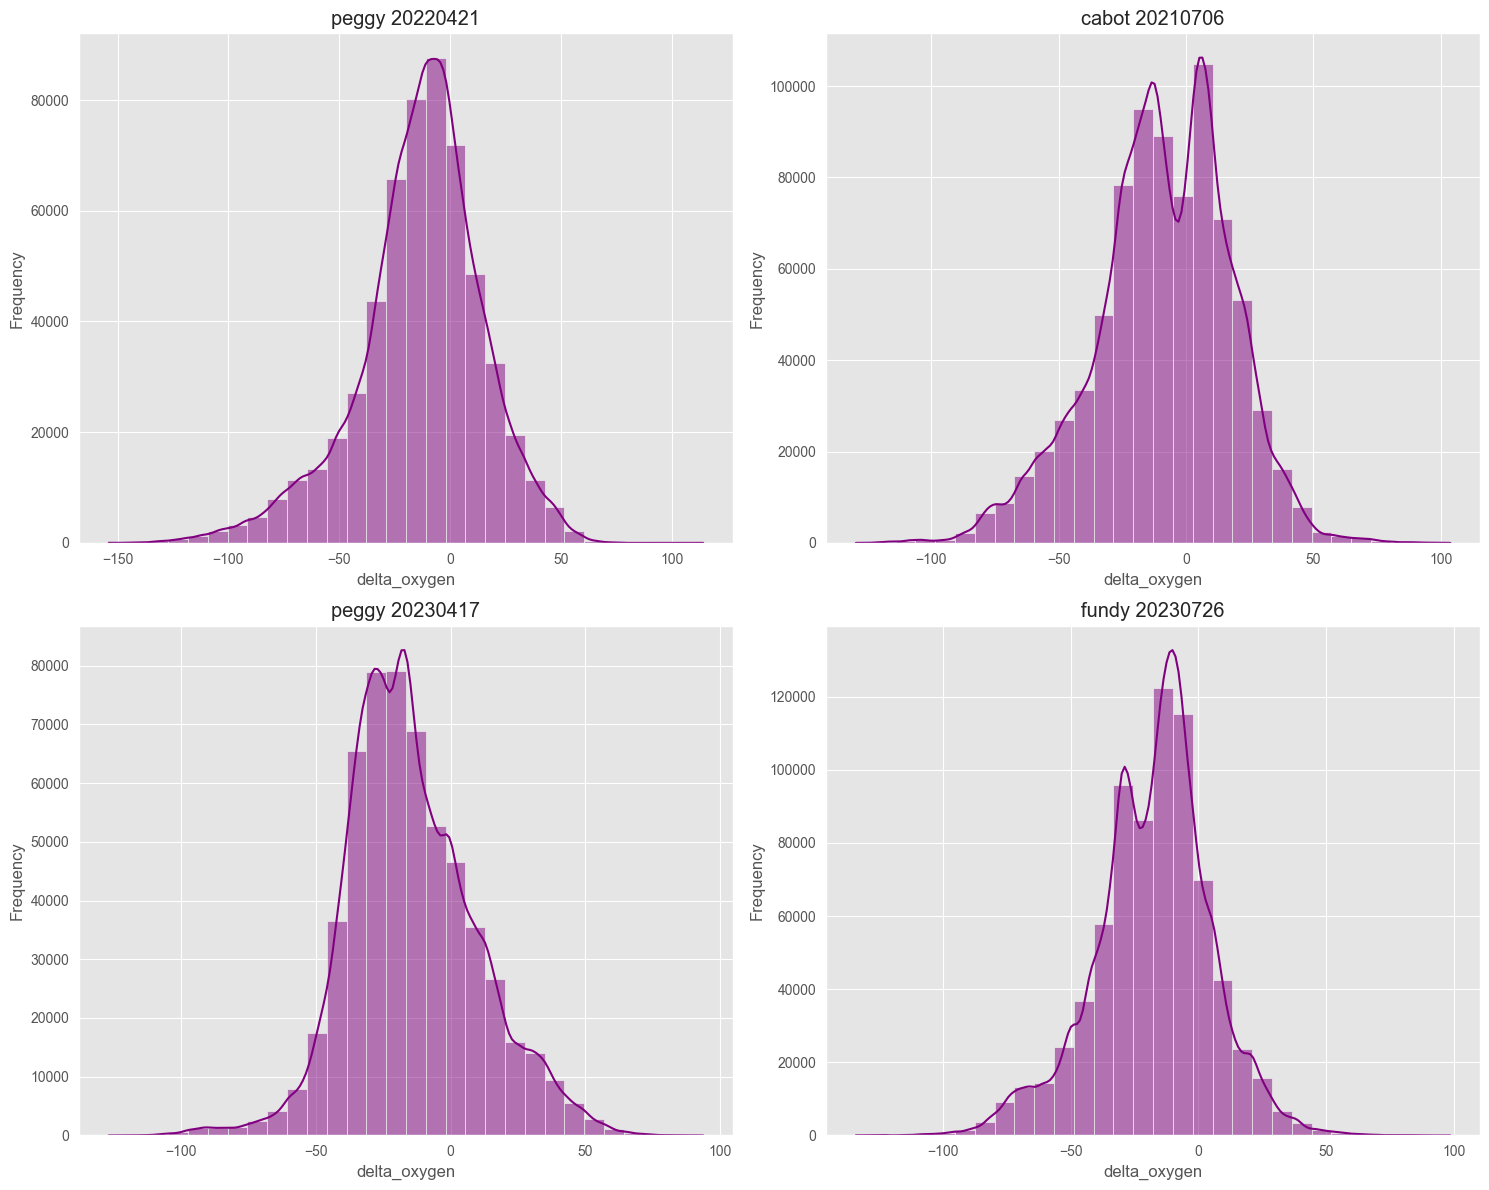

Temperature Discrepancy Distribution


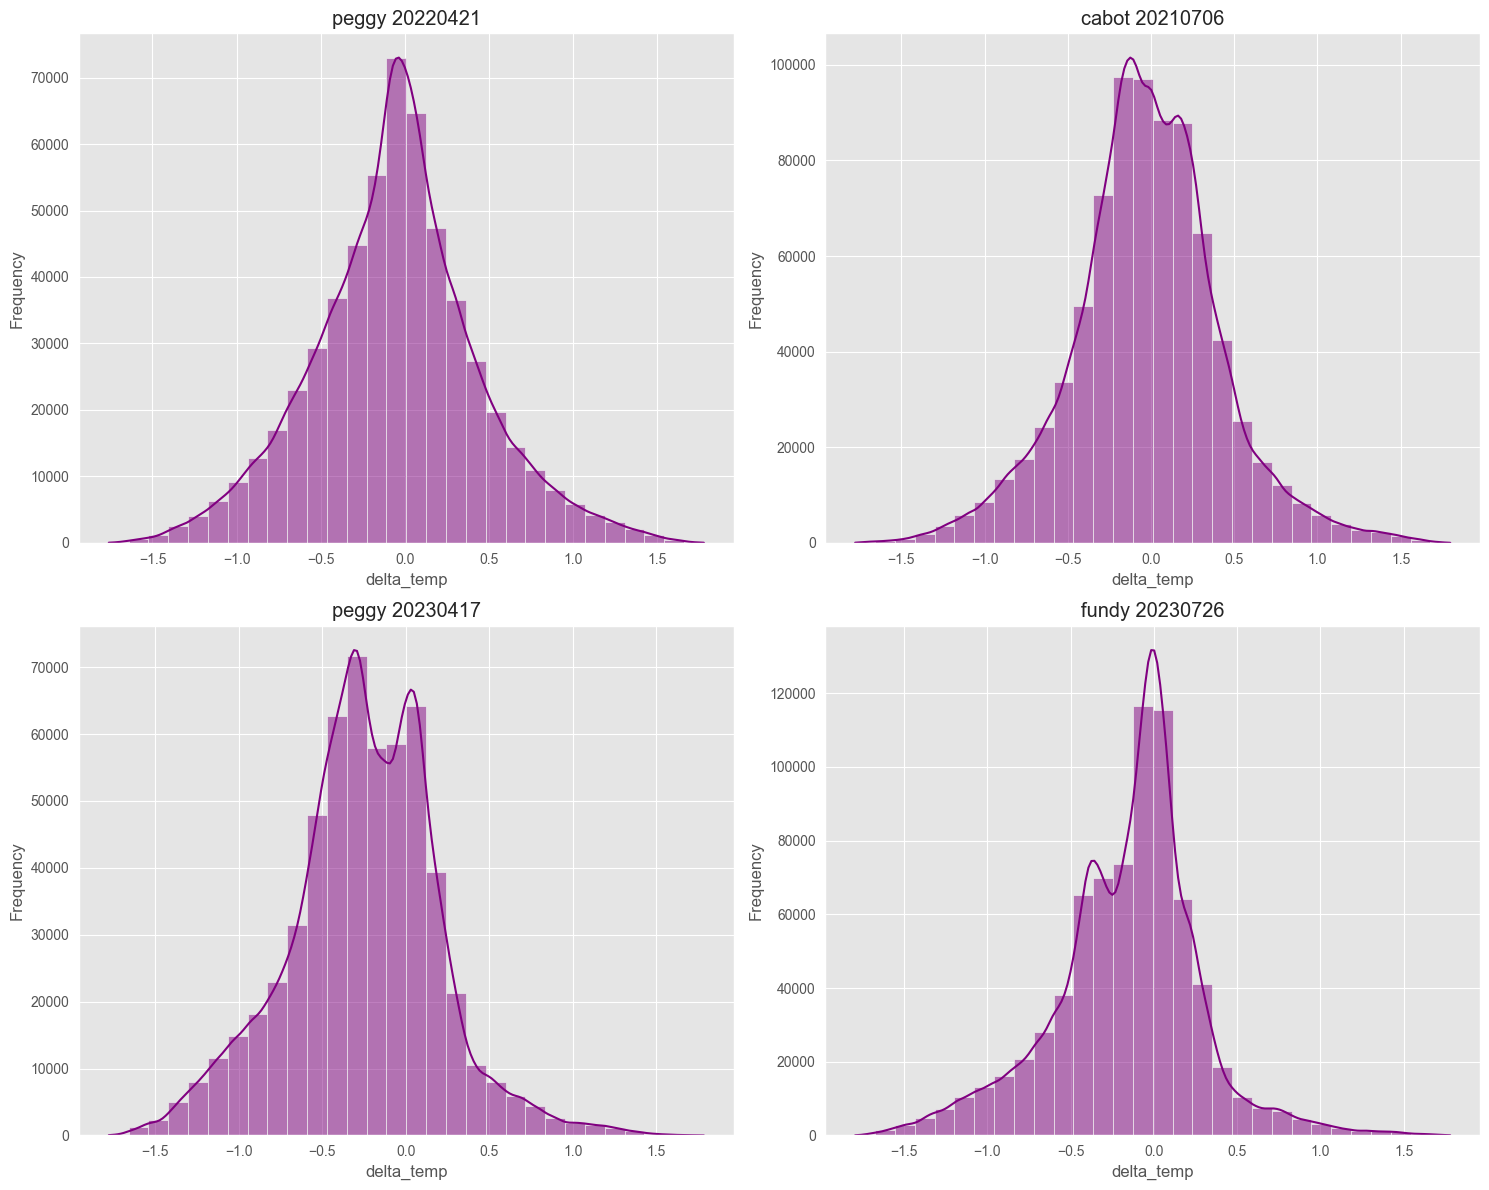

Salinity Discrepancy Distribution


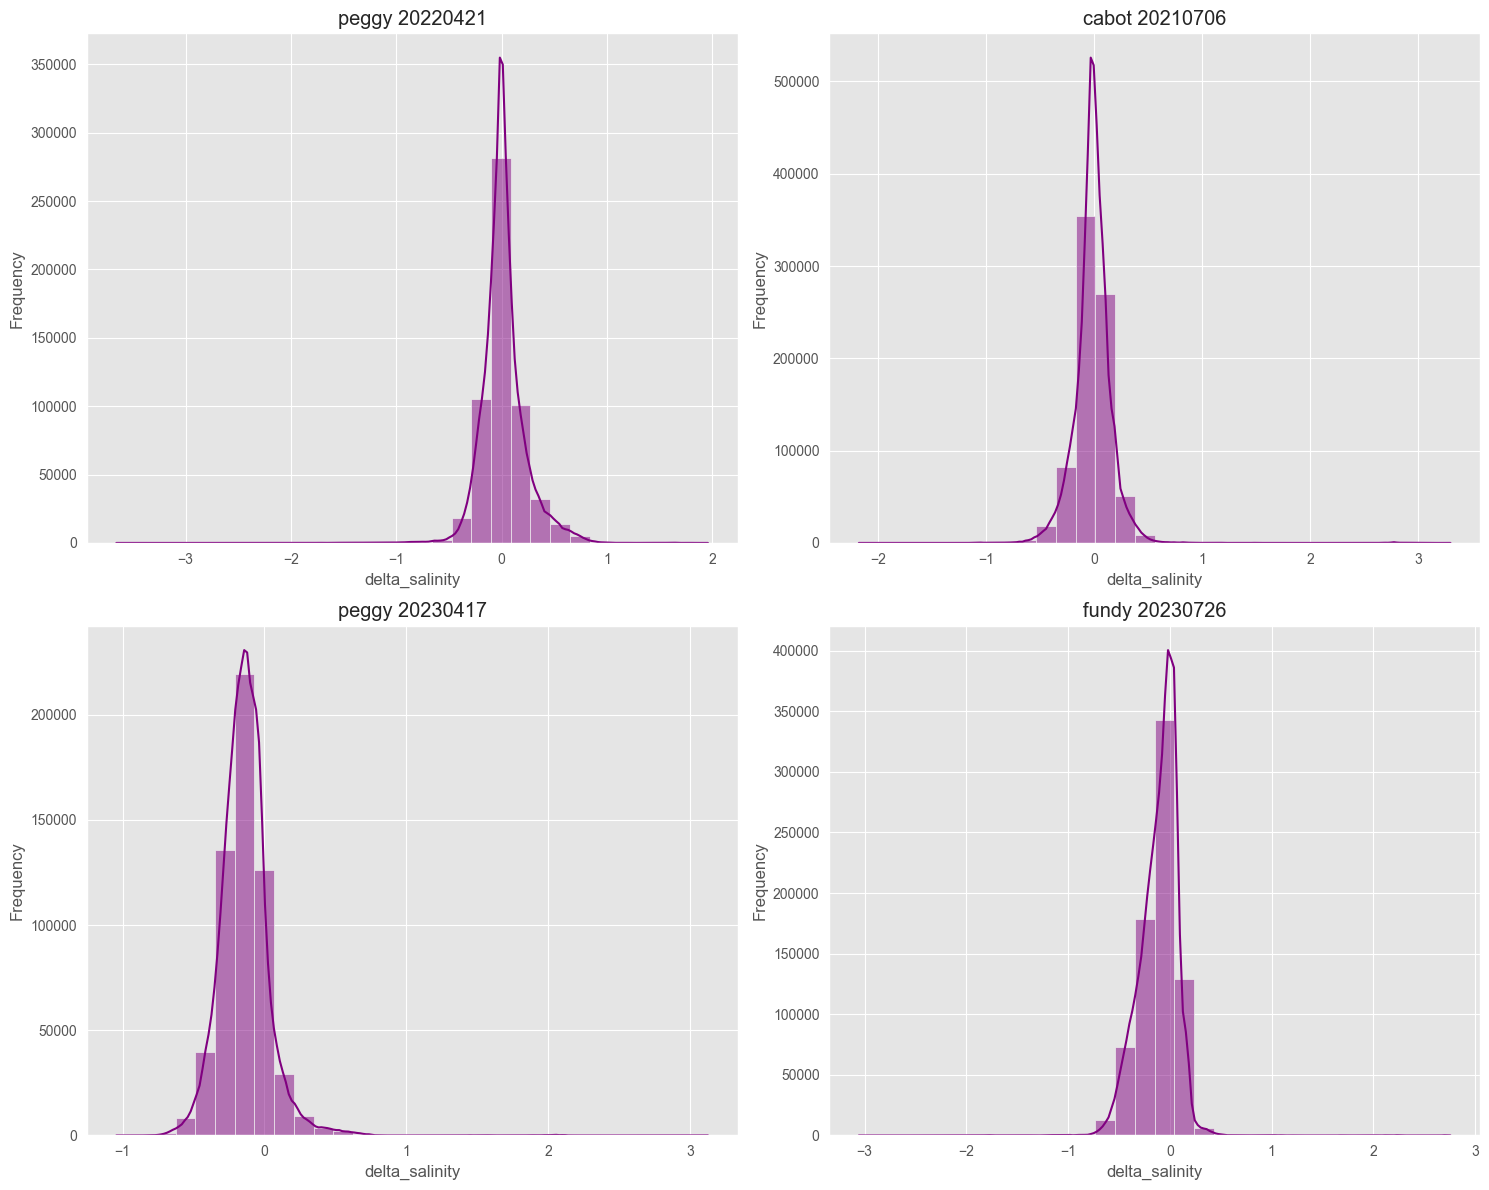

Density Discrepancy Distribution


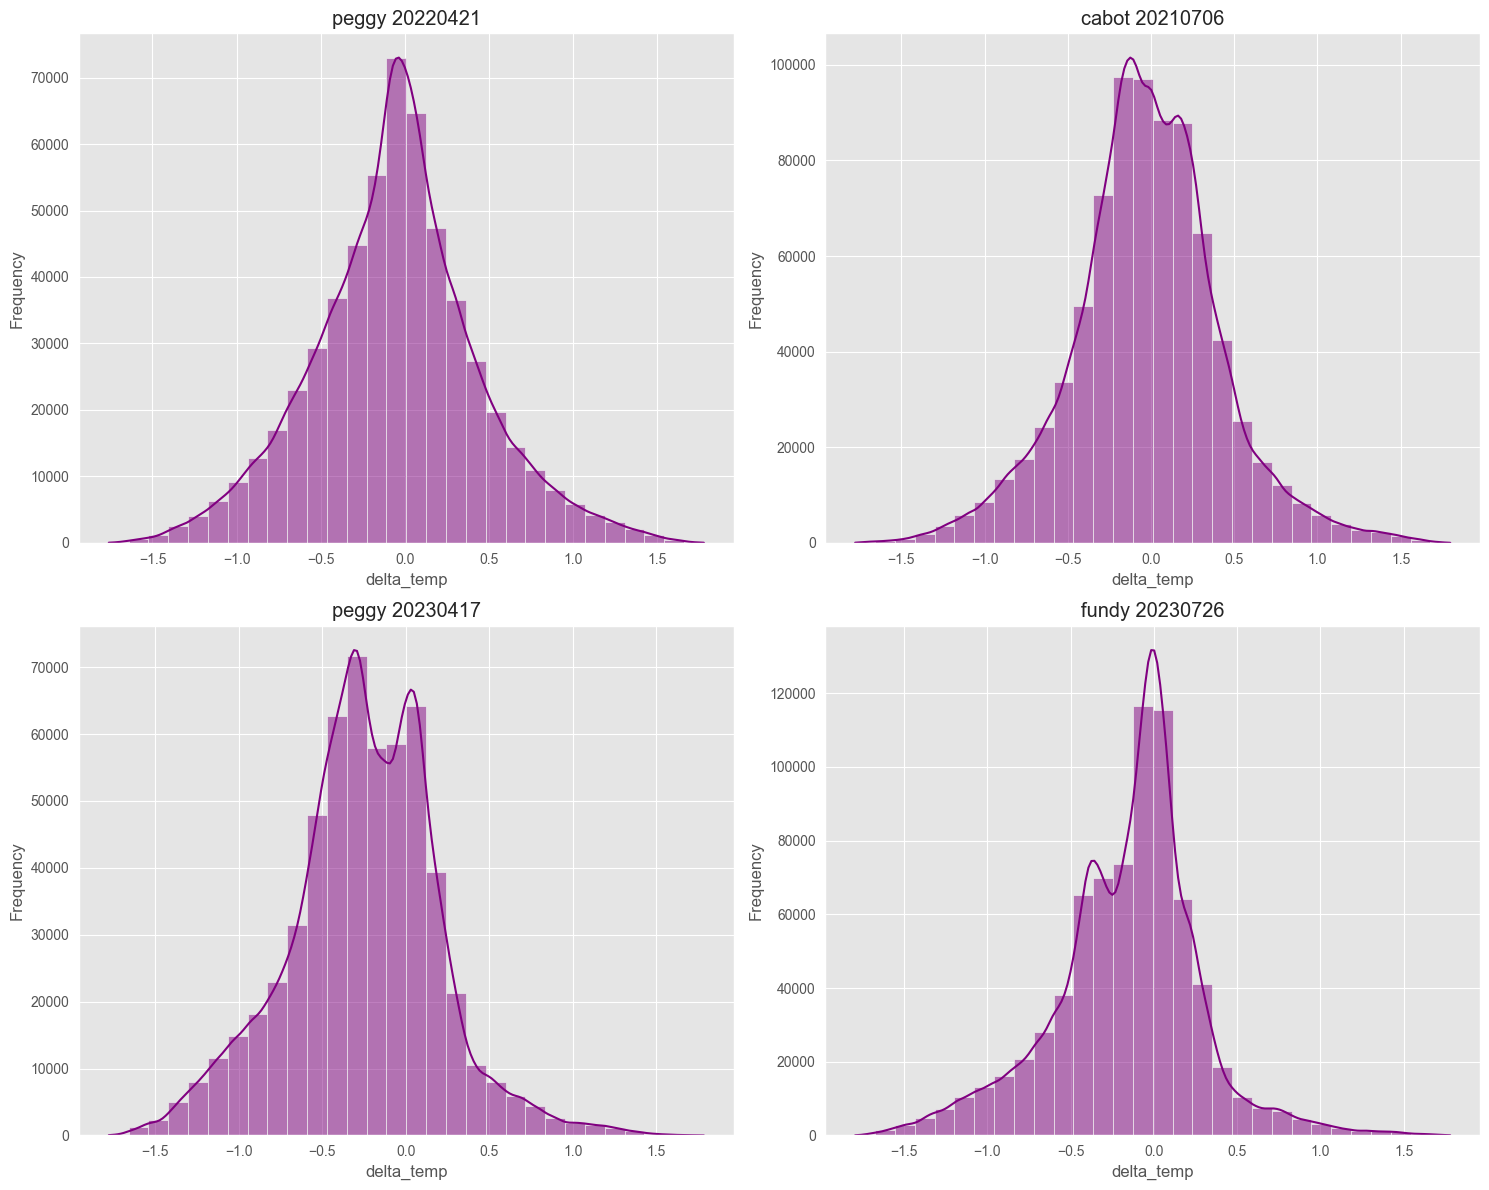

In [15]:
print("Oxygen Discrepancy Distribution")
gliders_drift_hist(combined_df, "delta_oxygen")

print("Temperature Discrepancy Distribution")
gliders_drift_hist(combined_df, "delta_temp")

print("Salinity Discrepancy Distribution")
gliders_drift_hist(combined_df, "delta_salinity")

print("Density Discrepancy Distribution")
gliders_drift_hist(combined_df, "delta_temp")

**Temperature and Density Discrepancy**
Across all glider missions, the temperature discrepancy shows a tightly centered distribution around zero, with most values falling within a narrow range of -1.5 to 1.5°C. In particular, the mission Peggy 20220421 stands out with a temperature discrepancy distribution that closely resembles a perfect normal distribution, suggesting consistent and minimal deviation from the ship-based reference measurements. This indicates that the thermal structure of the water column is being captured similarly by both the gliders and the ship-based sensors.

Interestingly, the density discrepancy distributions closely mirror the temperature discrepancy distributions across all missions. This similarity is expected because density in seawater is strongly dependent on both temperature and salinity, with temperature typically being the dominant driver, especially in upper ocean layers.

As a result, data alignment between gliders and ships looks quite good for these properties.

**Salinity Discrepancy**
Salinity discrepancy shows narrow, "skinny" distributions with a tight cluster around zero, suggesting very little variation overall. What stands out is the presence of significant outliers on both ends. This can be caused by our mismatch in longitude and latitude, especially since salinity can vary more rapidly across costal regions. 
However, these large deviations should not be a huge concern since they don’t represent the majority of the data.
Overall, the plot reinforces the idea that glider's salinity measurements are generally reliable, aside from a few extreme cases.

**Oxygen Discrepancy**

The Oxygen discrepancy distribution seems to have heavy left tail across the missions, indicating that gliders tend to underestimate oxygen concentrations relative to ship-based measurements. In addition, they are more spread out and particularly show more extreme negative values.

These patterns raise a critical question:

What Might Be Causing the Oxygen Discrepancy?
* Sensor Drifts? Oxygen sensors on gliders can be prone to biofouling, we want to see if the types of gliders and its duration have anything to do with the oxygen discrepancy.

* Different Spatial Coverage? If the gliders samples are from different water regions, we want to see if discrepancy changes depending on the locations.


In the next steps, we will visualize the spatial distribution of the discrepancy values for each mission. By mapping the discrepancy across latitude and longitude, we can assess whether huge discrepancy clusters in specific regions and whether glider missions in similar geographic zones show different discrepancy patterns.



### What Might Be Causing the Oxygen Discrepancy?

*Discrepancy in Oxygen Measured by Different Glider Missions*

In [16]:
# Get discrepancy in Oxygen by Glider Mission
def gliders_discrepancy_map(df):
    """
    Each panel shows the spatial distribution of absolute oxygen discrepancy in a given mission - larger, darker dots = more discrepancy.

    Goal: To assess whether discrepancy tends to occur in specific locations, suggesting systematic errors (e.g., sensor bias, regional ocean variability), or if it's more random.
    """
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # filter glider used for plotting
    gliders = ['peggy 20220421', 'cabot 20210706', 'peggy 20230417','fundy 20230726']
    for i, glider in enumerate(gliders):
        glider_df = df[df["mission_id"]==glider]
        glider_df['abs_oxygen_drift'] = glider_df['delta_oxygen'].abs()
        
        sns.scatterplot(data=glider_df, x='longitude', y='latitude', 
                        size ='abs_oxygen_drift', hue='abs_oxygen_drift',
                        ax=axes[i//2, i%2], s=20, alpha=0.7)
        
        axes[i//2, i%2].set_title(f'Discrepancy in Oxygen Measured By {glider}')
        axes[i//2, i%2].set_xlabel('Longitude')
        axes[i//2, i%2].set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

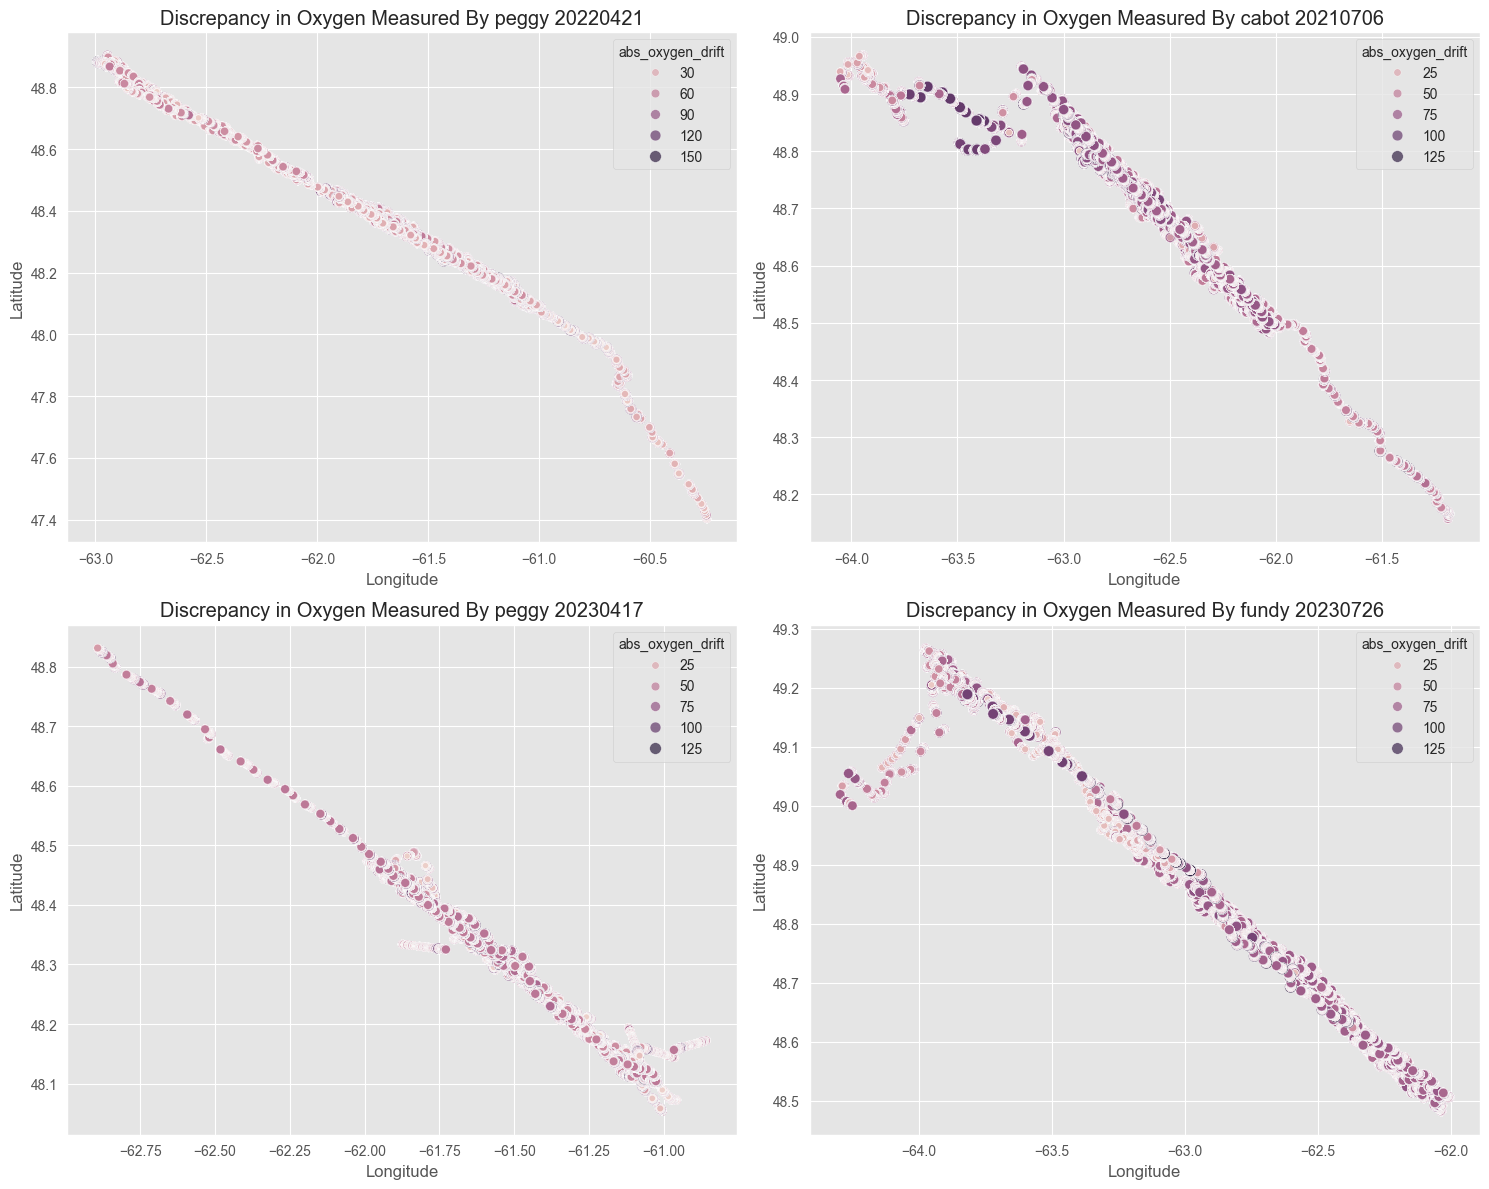

In [17]:
gliders_discrepancy_map(combined_df)

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

def glider_region_timeline(df):
    """
    Visualize a timeline of each glider's mission showing when they were in each region,
    with consistent region colors and a proper legend.
    """
    df['datetime'] = pd.to_datetime(df['datetime'])
    
    # Focus on a subset of gliders for clarity
    gliders = ['peggy 20220421', 'cabot 20210706', 'peggy 20230417', 'fundy 20230726']
    df = df[df['mission_id'].isin(gliders)]

    # Sort and group data
    grouped = df.sort_values('datetime').groupby(['mission_id', 'named_region'])

    segments = []

    for (glider, region), group in grouped:
        start_time = group['datetime'].min()
        end_time = group['datetime'].max()
        duration = (end_time - start_time).total_seconds() / (60 * 60 * 24)
        segments.append({
            'glider': glider,
            'region': region,
            'start': start_time,
            'end': end_time,
            'duration': duration
        })

    timeline_df = pd.DataFrame(segments)
    timeline_df.sort_values(['glider', 'start'], inplace=True)

    # Create a region color map
    unique_regions = timeline_df['region'].unique()
    color_palette = plt.cm.tab10.colors  # Choose another colormap if needed
    region_colors = {region: color_palette[i % len(color_palette)] for i, region in enumerate(unique_regions)}

    # Plot
    fig, ax = plt.subplots(figsize=(14, 6))

    for glider in timeline_df['glider'].unique():
        g_data = timeline_df[timeline_df['glider'] == glider]
        for _, row in g_data.iterrows():
            ax.barh(
                y=glider,
                width=row['duration'],
                left=row['start'],
                height=0.4,
                color=region_colors[row['region']],
                edgecolor='black'
            )

    # Legend
    handles = [plt.Rectangle((0, 0), 1, 1, color=color) for region, color in region_colors.items()]
    labels = list(region_colors.keys())
    ax.legend(handles, labels, title='Region', bbox_to_anchor=(1.01, 1), loc='upper left')

    ax.set_xlabel("Time")
    ax.set_ylabel("Glider Mission")
    ax.set_title("Timeline of Glider Movement Across Regions")
    plt.tight_layout()
    plt.show()


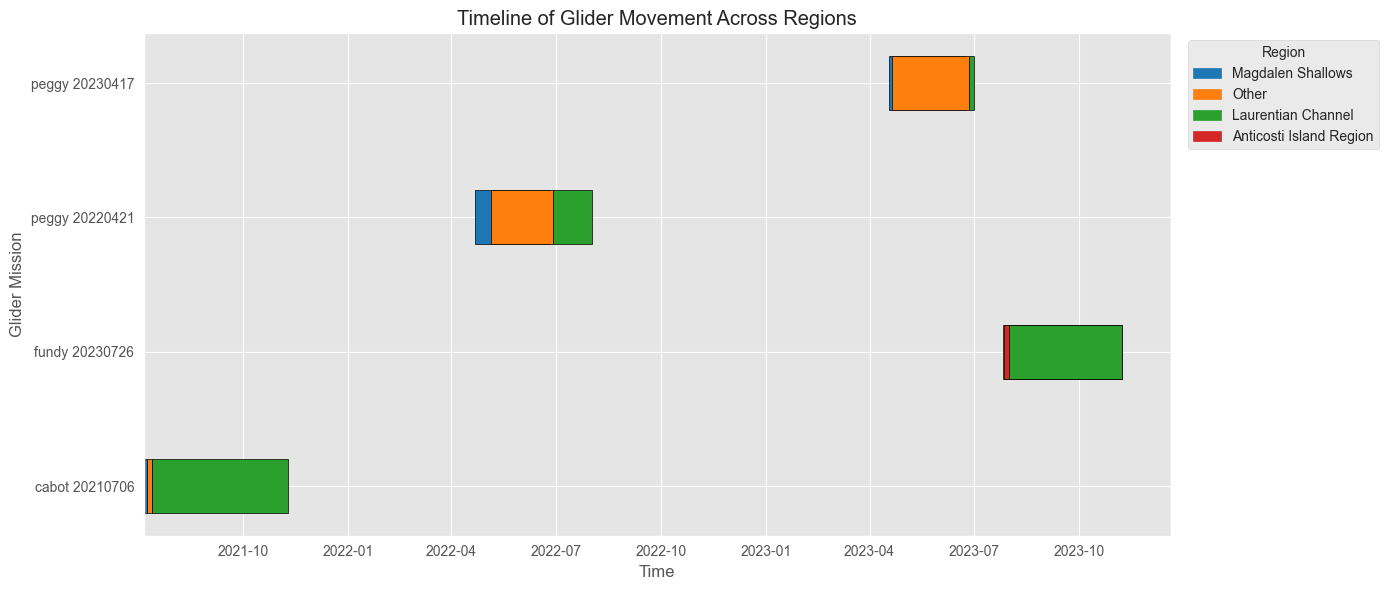

In [21]:
glider_region_timeline(combined_df)

It appears that each glider mission covered a distinct spatial region, with only minimal overlap between them. The Fundy and Cabot missions primarily operated in the northwestern section of Gulf of Saint Lawrence (approximately longitude -64° to -61.5°, latitude 48.2° to 49.3°), whereas the Peggy missions focused further south, around 47.4° to 48.8°N.

The cluster of higher oxygen discrepancy values appears around latitude 48.5° and becomes more magnified moving westward. This pattern is shown in the Cabot and Fundy missions, both of which sampled this region. This means that the environmental factors in Laurentian Channel might play a role in th oxygen measurement drift.

In the few overlapping spatial zones across different glider missions, the oxygen discrepancy appears to be relatively consistent. This suggests that the observed differences in discrepancy are more likely influenced by regional environmental conditions, such as water mass variability.

### Investigate Oxygen Discrepancy Across Different Regions

In [19]:
# Create boxplots comparing discrepancy in Oxygen Measured by Different Glider Missions

def plot_discrepancy_comparison(x_var, y_var, ylabel):
    plt.figure(figsize=(14, 6))
    sns.boxplot(data=combined_df, x=x_var, y=y_var, hue='layer', 
               order=combined_df[x_var].value_counts().index)
    plt.title(f'{y_var.capitalize()} Distribution by {x_var} and Depth Layer')
    plt.ylabel(ylabel)
    plt.xlabel(x_var.capitalize())
    plt.legend(title='Depth Layer')
    plt.tight_layout()
    plt.show()

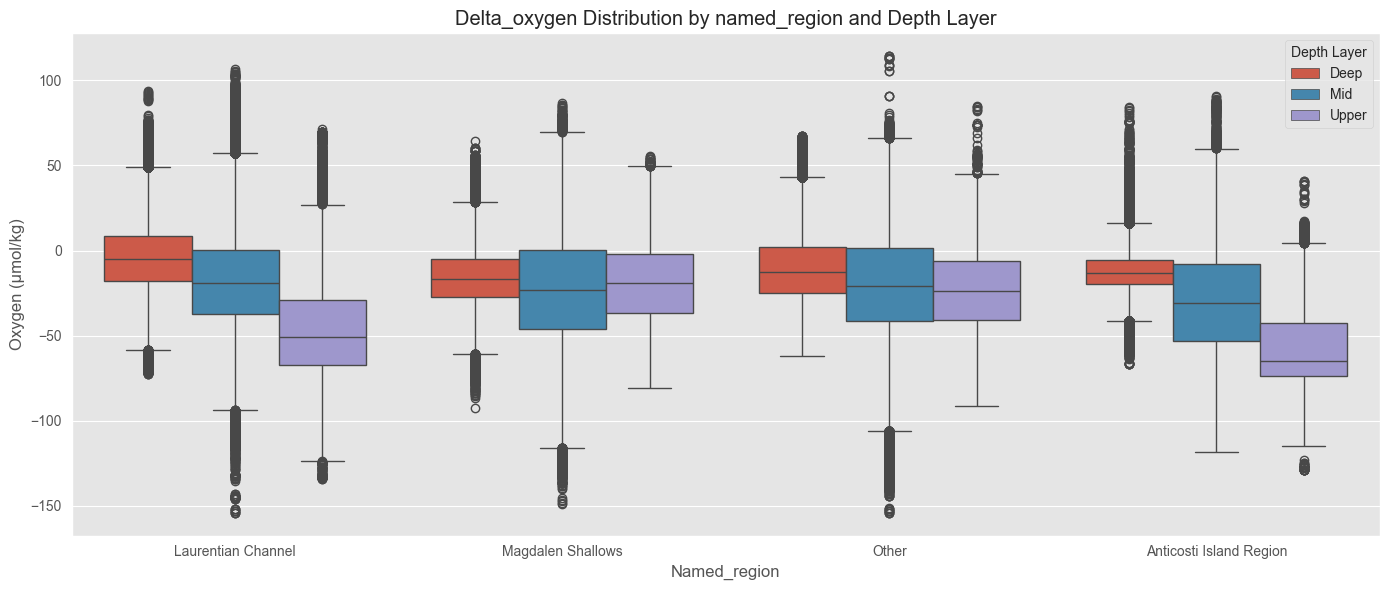

In [20]:
plot_discrepancy_comparison('named_region','delta_oxygen', 'Oxygen (μmol/kg)')

The plot suggests a consistent trend accross regions which is the discrepancy between the glider and ship oxygen measurements decreases as the gliders go deeper into the water column.

This trend makes intuitive sense as the gliders descend into deeper waters, the physical properties of the water, such as temperature, salinity, and oxygen levels, become more stable (shown in the graph below). Unlike surface waters, which are subject to frequent fluctuations due to factors like weather, tides, and day-night cycles, deeper waters exhibit much less variation in these parameters.

This stability in deeper waters means that the oxygen levels remain relatively constant, and therefore, the sensors on both the ship and the glider are measuring similar oxygen levels, leading to a reduced discrepancy between their measurements. 

In conclusion, the reduced oxygen sensor discrepancy in deeper waters can be attributed to the more stable and consistent environmental conditions at those depths, which minimizes the natural fluctuations that might otherwise affect the accuracy of the measurements taken by the glider and ship sensors.

It is also worth noting that regions like Laurentian Channel and Anticosti Island have relatively significant shift in the mean discrepancy between layers. Next we will explore water mass in these regions and see if that has anything to do with this phenomenon.




In [25]:
# Plot features vs depth
def features_vs_depth(df):
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    features = ['temperature', 'density', 'salinity', 'Oxygen_ship']

    for i, feature in enumerate(features):
        sns.scatterplot(data=df, x='depth', y=feature, 
                        color='purple',
                        ax=axes[i//2, i%2], s=20, alpha=0.7)
        
        axes[i//2, i%2].set_title(f'{feature} vs Depth')
        axes[i//2, i%2].set_xlabel('Depth')
        axes[i//2, i%2].set_ylabel(feature)

    plt.tight_layout()
    plt.show()


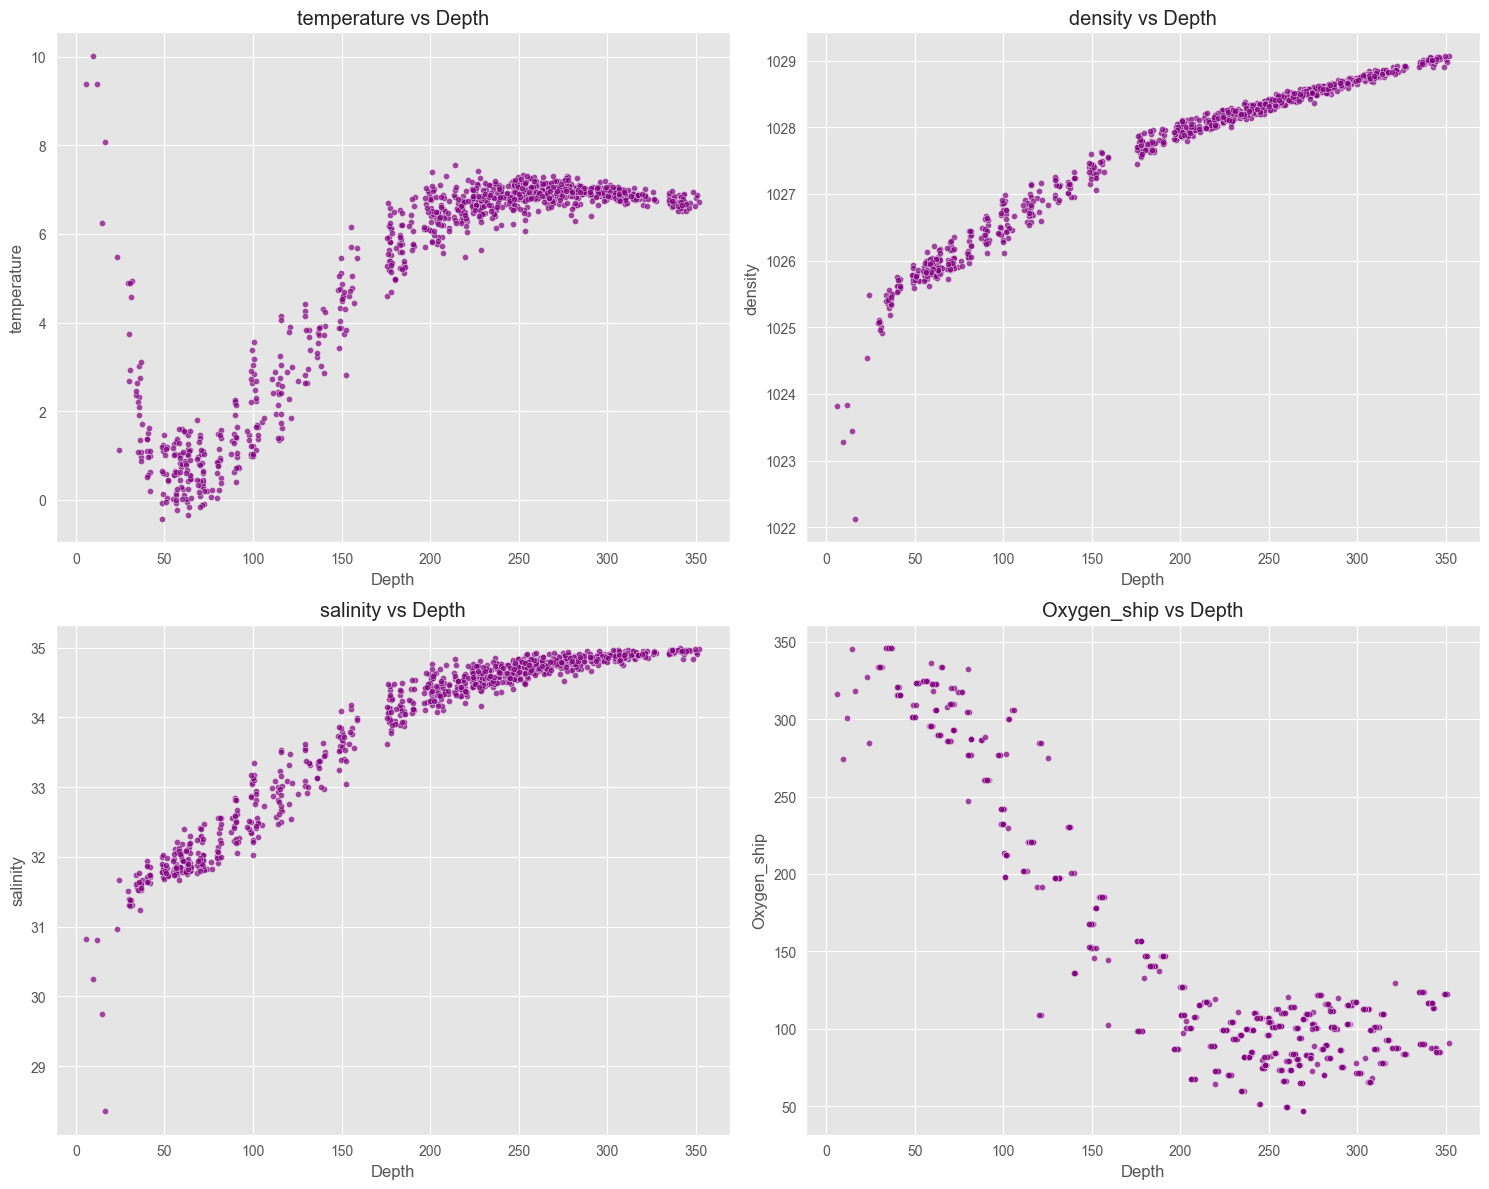

In [26]:
features_vs_depth(test_df) #use test_df which samples combined_df for faster run

*What Water Masses Influence Larger Discrepancies?*

In [27]:

def plot_features_vs_region(df, x_var, y_var):
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # filter region used for plotting
    regions = ["Laurentian Channel", "Magdalen Shallows", "Anticosti Island Region", "Other"]
    for i, rg in enumerate(regions):
        region_df = df[df["named_region"]==rg]
                
        sns.scatterplot(data=region_df, x=x_var, y= y_var, hue ='abs_delta_oxygen',
                        size='abs_delta_oxygen', sizes=(20,100), 
                        ax=axes[i//2, i%2], alpha=0.7)
        
        axes[i//2, i%2].set_title(f'{y_var.capitalize()} vs {x_var.capitalize()} colored by oxygen discrepancy intensity in {rg}')
        axes[i//2, i%2].set_xlabel(x_var)
        axes[i//2, i%2].set_ylabel(y_var)

    plt.tight_layout()
    plt.show()


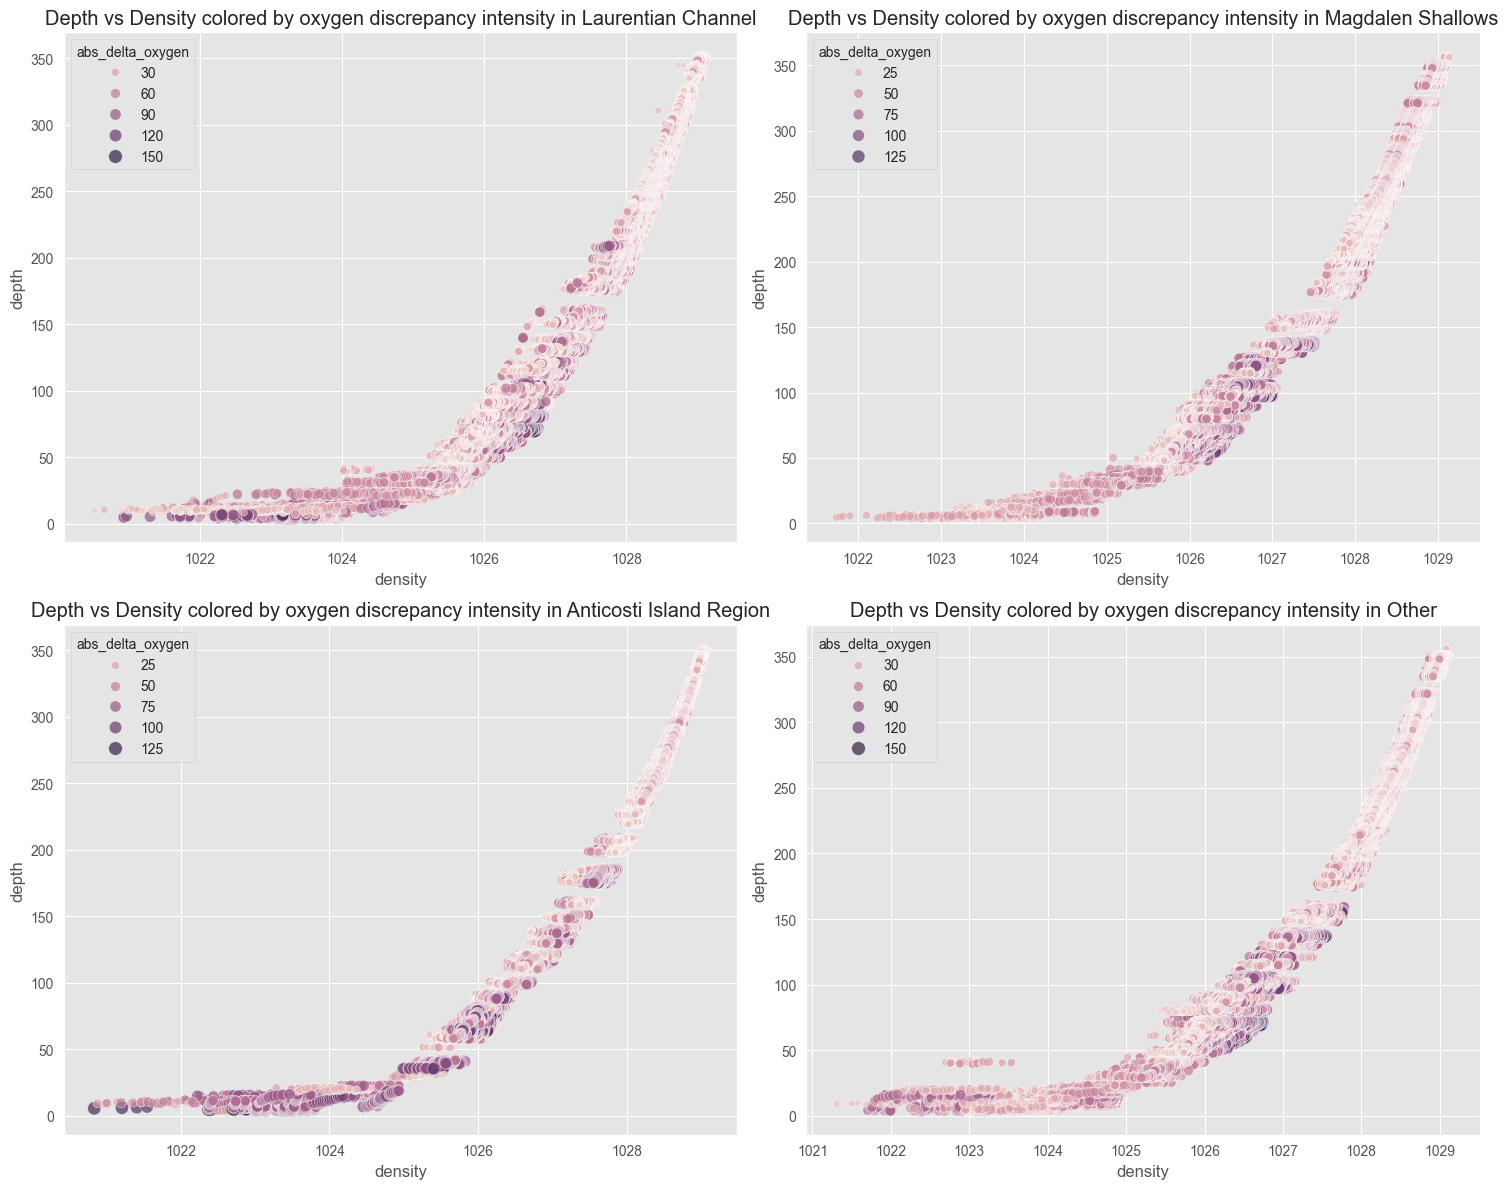

In [28]:
plot_features_vs_region(combined_df, 'density', 'depth')

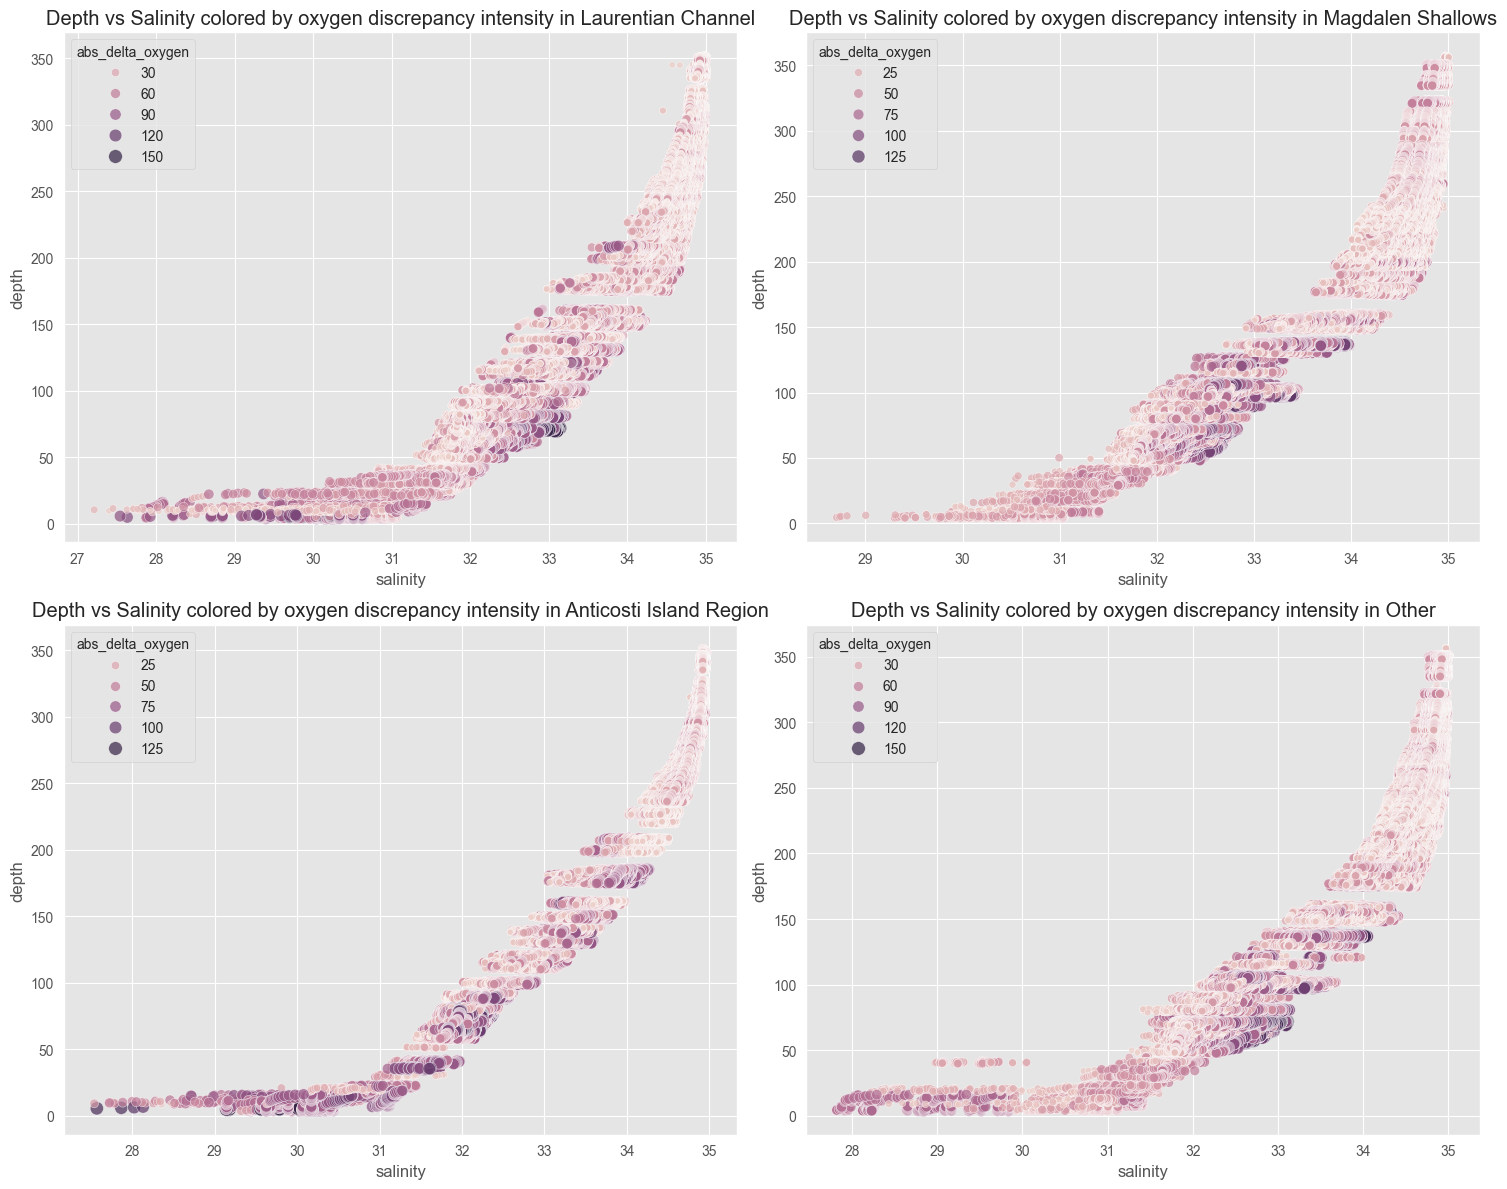

In [29]:
plot_features_vs_region(combined_df, 'salinity','depth')

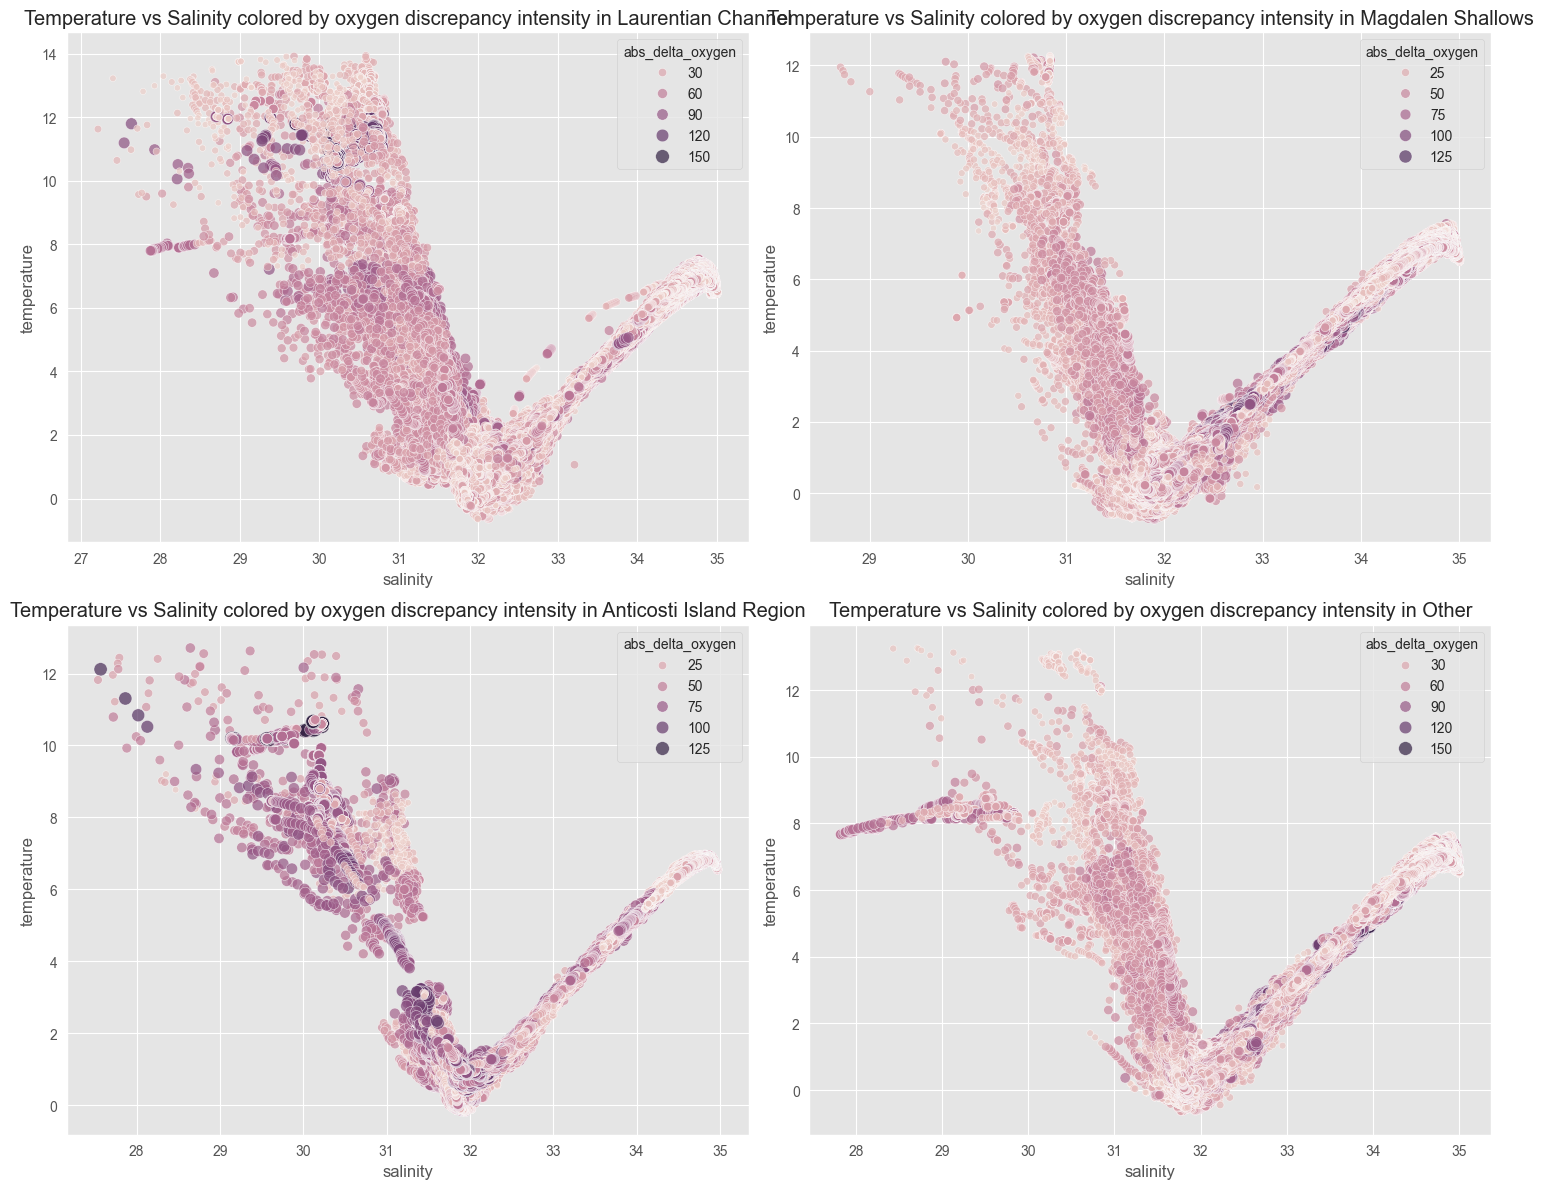

In [30]:
plot_features_vs_region(combined_df, 'salinity', 'temperature')

The Temperature and Salinity diagrams across the four regions show similar water mass structures and a common pattern that oxygen discrepancy is more pronounced in fresher waters. However, the  magnitude of oxygen discrepancy varies in regions, indicating that discrepancy is influenced by regional environmental factors, and not only physical water mass properties.

Anticosti Island Region shows some of the highest and most concentrated oxygen discrepancy, especially in fresher waters (~28-30 PSU salinity). Some environmental factors that are worth discussing are photosynthesis and biofouling. In the surface layer, phytoplankton continuously produce oxygen during daylight hours. This results in high oxygen concentrations, particularly in coastal or biologically active areas. As a result, sensors may detect spikes in oxygen levels due to nearby phytoplankton blooms. 

If ship-based and glider sensors are not sampling the same location at the same time, mismatches can occur. Even small mismatches in time and location between ship and glider measurements can create artificial discrepancy, especially in biologically dynamic regions where oxygen levels can change rapidly over short distances or hours. Additionally, phytoplankton can attach to the sensor, locally influencing oxygen production or consumption, further disrupting accuracy.

Different regions might experience varying effects from photosynthesis and biofouling which leads to various magnitude of oxygen discrepancy. This suggests that discrepancy size is not solely determined by physical water mass properties but is also influenced by factors such as glider deployment timing and region-specific environmental conditions.

In the Magdalen Shallows and Other regions, discrepancy behaves a bit differently, with higher values in saltier water. Since Peggy was the only glider to sample these regions, it’s possible the observed trend is linked to that specific glider’s oxygen sensor. Sensor response degradation at depth may explain this deviation.

*Relationships between Magnitude of Oxygen Discrepancy and Environmental Variables*

In [32]:
def oxygen_discrepancy_vs_features(df):
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    features = ['temperature', 'density', 'salinity', 'depth']

    for i, feature in enumerate(features):
        sns.scatterplot(data=df, x=feature, y='abs_delta_oxygen',
                        hue='named_region',
                        ax=axes[i//2, i%2], s=20, alpha=0.7)
        
        axes[i//2, i%2].set_title(f'Oxygen Discrepancy vs {feature}')
        axes[i//2, i%2].set_ylabel('Oxygen')
        axes[i//2, i%2].set_xlabel(feature)

    plt.tight_layout()
    plt.show()

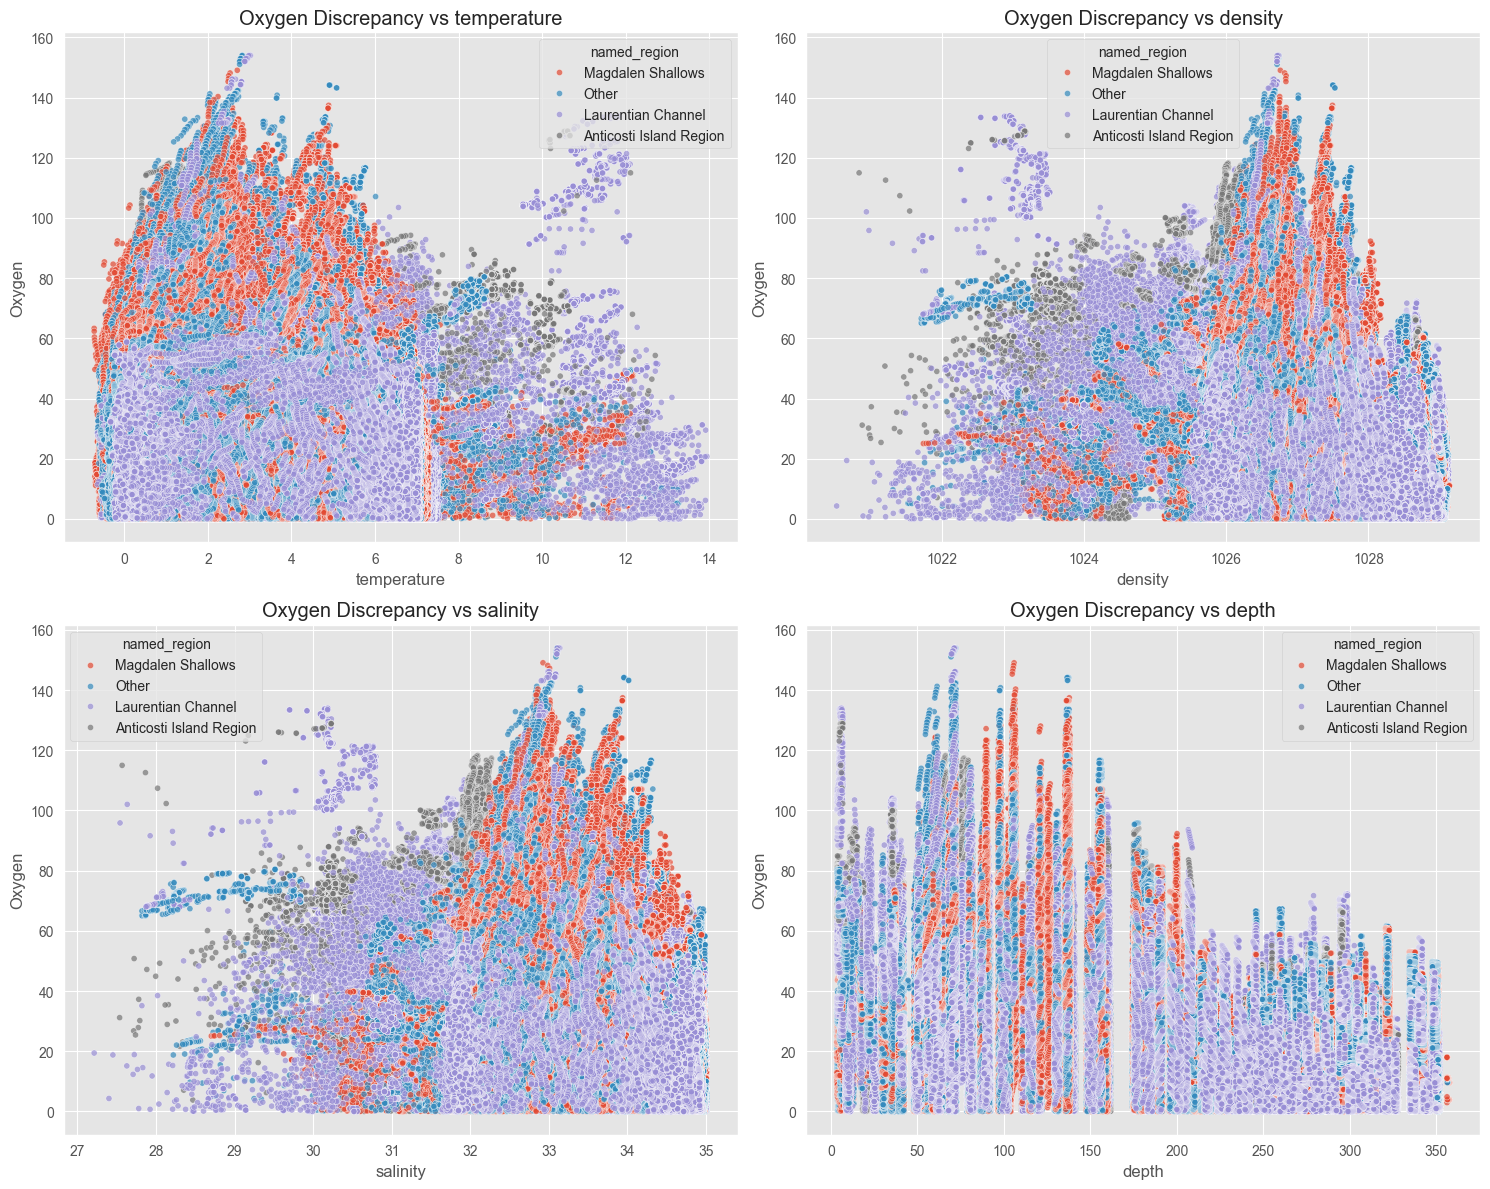

In [33]:
oxygen_discrepancy_vs_features(combined_df)

## 

Since the discrepancy magnitude shows clear patterns and is not random, we can develop a machine learning model using environmental variables to predict the oxygen discrepancy. This approach would not only improve our understanding of discrepancy behavior but also help identify which variables have the most significant impact on sensor discrepancy through feature importance analysis.

# Build Model

**Drop Redundant Variables**

In [34]:
df_model= combined_df.drop(columns=['datetime', 'lat_bin',
                        'lon_bin', 'region_bin', 'layer',
                        'Latitude_ship', 'Longitude_ship',
                        'Depth_ship', 'Temp_ship', 'Salinity_ship', 'Density_ship',
                        'oxygen', 'Oxygen_ship', 'delta_temp', 'delta_salinity',
                        'delta_density', 'abs_delta_oxygen'])



Since we are trying to predict the oxygen discrepancy from gliders' oxygen concentration measurement, we decided to use glider's features measurements and removed the ones from ship. This is because when deploying a glider, there is no ship data available so the model needs to rely on what the glider collects.

In [35]:
# Select only categorical columns for dummy variable creation
categorical_columns = ['named_region', 'mission_id']  
df_model = pd.get_dummies(df_model, columns=categorical_columns)

# Display the updated DataFrame information
df_model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2673784 entries, 0 to 2673783
Data columns (total 17 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   latitude                              float64
 1   longitude                             float64
 2   depth                                 float64
 3   temperature                           float64
 4   salinity                              float64
 5   density                               float64
 6   month                                 int32  
 7   year                                  int32  
 8   delta_oxygen                          float64
 9   named_region_Anticosti Island Region  bool   
 10  named_region_Laurentian Channel       bool   
 11  named_region_Magdalen Shallows        bool   
 12  named_region_Other                    bool   
 13  mission_id_cabot 20210706             bool   
 14  mission_id_fundy 20230726             bool   
 15  mission_id_pegg

**Gradient Boosting**

Oxygen concentration differences between glider and ship-based measurements in the Gulf of Saint Lawrence are influenced by a range of environmental conditions. Initially, our objective was to predict the magnitude of discrepancy using the absolute value of the difference (|glider – ship|), assuming that the discrepancy underestimation/overestimation by gliders was less important than the size of the error. However, further model experimentation revealed that using the raw differnece (delta_oxygen) significantly improved predictive performance — achieving an R² of ~74%, compared to ~50% for the absolute value version.

This improvement suggests that whether the glider over- or underestimates oxygen concentrations is systematically influenced by oceanographic conditions and mission-specific factors. Environmental variables such as depth, salinity, and density not only influence how much discrepancy occurs, but also in what direction. Capturing this directional bias helps the model learn more precise patterns about when gliders differ from ships.

To model this, we used a Histogram-based Gradient Boosting Regressor (HistGradientBoostingRegressor), which was selected due to its ability to capture complex nonlinear interactions between physical variables without extensive manual feature engineering, handle collinearity effectively (salinity and density are highly correlated), and assign importance to the most informative features.


In [36]:
#Use a smaller sample for try out the model

sample_df = df_model.sample(500000, random_state=42)

In [37]:

from sklearn.model_selection import train_test_split

#Get X and y
X = sample_df.drop(columns=['delta_oxygen'])
y = sample_df['delta_oxygen']

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.2, random_state=42)

In [38]:
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_depth=20, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("Metrics for the first model:")
print("MAE:", mean_absolute_error(y_test, y_pred) )
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:",r2_score(y_test, y_pred))

Metrics for the first model:
MAE: 10.836534710417874
MSE: 210.94001813226876
R2 Score: 0.6783340851101405


**Improving the Model**

*Identify the Top Feature Importance*

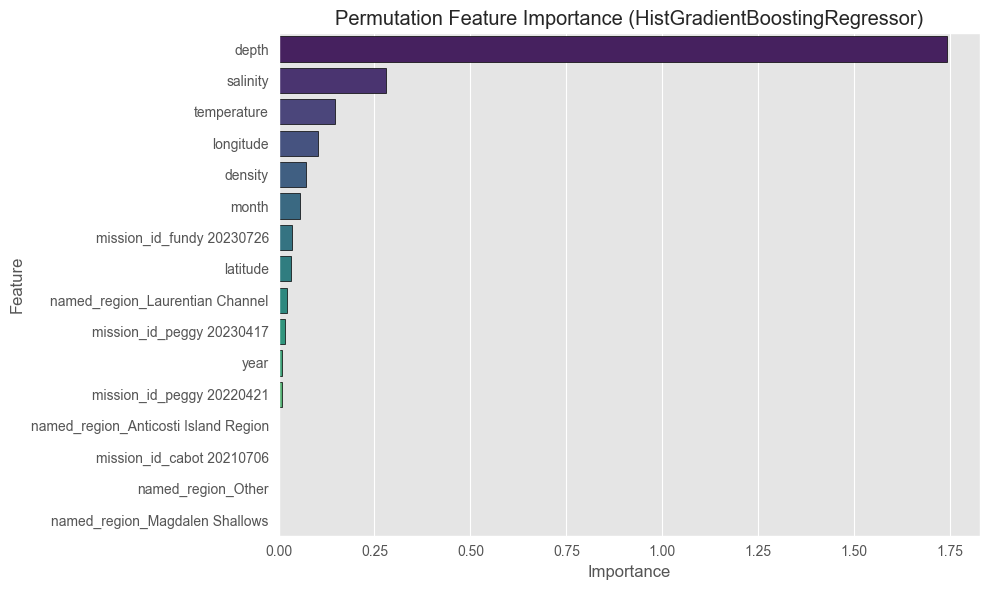

In [40]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organize results
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='viridis', edgecolor='k')
plt.title("Permutation Feature Importance (HistGradientBoostingRegressor)")
plt.tight_layout()
plt.show()


Based on the analysis, it appears that the **mission ID** and **region** variables are less influential in the model compared to other features. This is understandable, as region names are derived from longitude and latitude, which have already been included in the model. Additionally, the **mission ID** does not appear to have a meaningful contribution to explaining the oxygen discrepancy, as observed from the previous analysis. Therefore, we will exclude these variables from the model moving forward.

In [41]:
#reduced low importance features to see if we can get better results
X_new = X.drop(columns=['named_region_Anticosti Island Region', 'named_region_Other', 'named_region_Laurentian Channel', 
                        'named_region_Magdalen Shallows',
                        'mission_id_cabot 20210706', 'mission_id_fundy 20230726',
                        'mission_id_peggy 20220421', 'mission_id_peggy 20230417',
                        'year'
                        ])



In [42]:
#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
	X_new, y, test_size=0.2, random_state=42)

In [43]:
from sklearn.ensemble import HistGradientBoostingRegressor 
model = HistGradientBoostingRegressor(max_depth=20, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



In [44]:
print("Metrics after dropping low importance features:")
print("MAE:", mean_absolute_error(y_test, y_pred) )
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:",r2_score(y_test, y_pred))

Metrics after dropping low importance features:
MAE: 11.160333787084932
MSE: 220.4401977821812
R2 Score: 0.6638471043761627


The Model's metrics seem to decrease slightly, indicating that the removed features still contributed somewhat to the model's performance despite their low importance. However, the changes are relatively small, suggesting that the drop in performance is not drastic.

Since the drop is insignificant, it should not raise any concerns and we are willing to take the trade-off here for a simpler model.

*Residual*

<Figure size 1000x600 with 0 Axes>

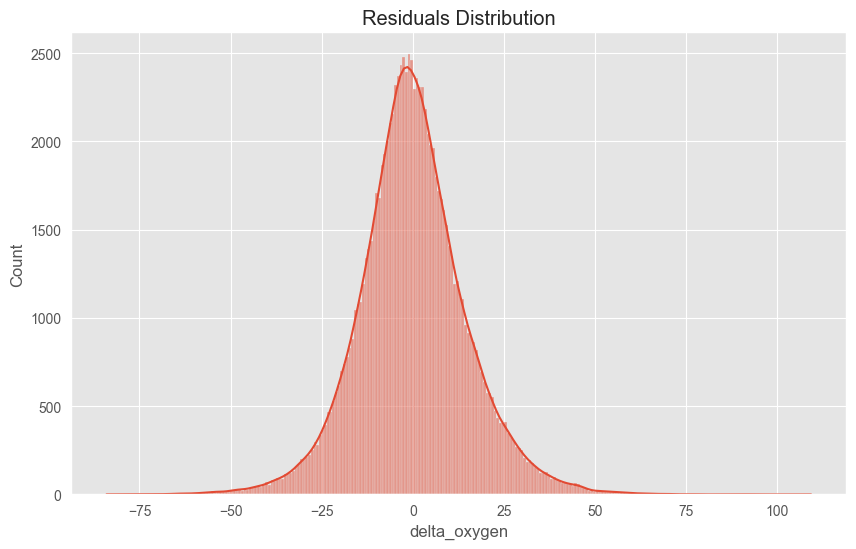

In [45]:

plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title("Residuals Distribution")
plt.show()


This is a good sign that the Residual Plot centers around 0 and skinny, meaning low variance for most predictions.

However, the plot has extreme long tails (especially the right side). This indicates outliers or cases with large overpredictions. Due to the time limitations of this project, we will skip exploring the potential issues behind this phenomenon.

*Tuning Hyperparameters*

In [ ]:

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'max_depth': [18, 19, 20],
    'learning_rate': [0.085],
    'max_iter': [302, 305, 308],
    'min_samples_leaf': [100],
}

model = HistGradientBoostingRegressor()
search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, 
                            scoring='neg_mean_absolute_error', cv=3, random_state=42, n_jobs=-1)
search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best MAE:", search.best_score_)


*Run New Model Using the Best Parameters*

In [46]:
# Use the best parameters from the search
best_params = {
    'min_samples_leaf': 100,
    'max_iter': 308,
    'max_depth': 19,
    'learning_rate': 0.085
}
# Create a new model with the best hyperparameters
new_model = HistGradientBoostingRegressor(**best_params, random_state=42)
new_model.fit(X_train, y_train)

y_pred = new_model.predict(X_test)

print("Metrics after tuning and dropping low importance features:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Metrics after tuning and dropping low importance features:
MAE: 9.973758588634318
MSE: 181.67530486524797
R²: 0.7229603293400191


The R² score has increased from 0.6638 to 0.72296, which means the model now explains about 72.3% of the variance in the target variable, compared to 66.38% before. This is a great improvement, indicating that the tuned model is better at capturing the underlying patterns and trends in the data, with better prediction accuracy (lower MAE), fewer large errors (lower MSE). This suggests that the tuning process was successful, and the model is now performing better while potentially being simpler and more efficient.

*Exploring Correlations between Feature Variables*

<Axes: >

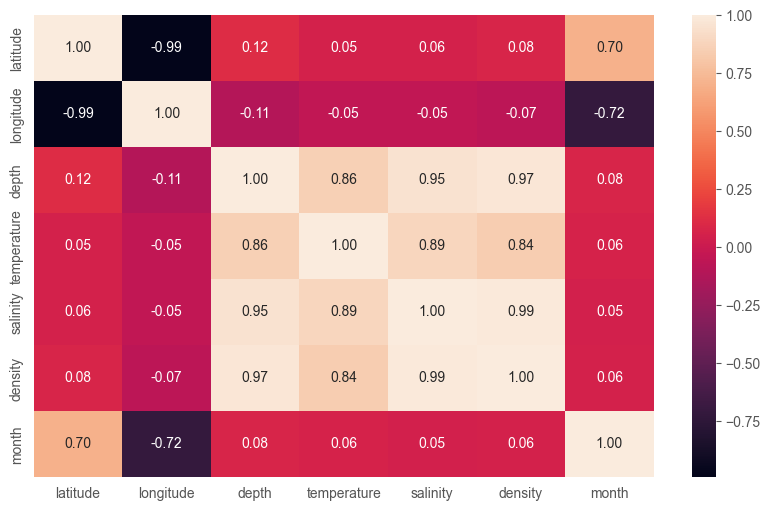

In [47]:
plt.figure(figsize=(10, 6))
sns.heatmap(X_new.corr(), annot=True, fmt=".2f")

In [48]:
X_new['salinity_density'] = X_new['salinity'] * X_new['density']
X_new['depth_density'] = X_new['depth'] * X_new['density']
X_new['temp_salinity'] = X_new['temperature'] * X_new['salinity']
X_new['depth_salinity'] = X_new['depth'] * X_new['salinity']
X_new['depth_temp'] = X_new['depth'] * X_new['temperature']


In [49]:

#Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
	X_new, y, test_size=0.2, random_state=42)

In [50]:

# Create a new model with the best hyperparameters
final_model = HistGradientBoostingRegressor(**best_params, random_state=42)

# Fit it on updated dataset (with interaction terms now included)
final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = final_model.predict(X_test)



In [51]:
print("Metrics after adding interaction terms:")
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

Metrics after adding interaction terms:
MAE: 9.826506757929439
MSE: 172.5818880164428
R²: 0.7368270307655952


The model has shown further improvements after adding interaction terms, with better prediction accuracy (lower MAE), fewer large errors (lower MSE), and an increased ability to explain variance (higher R²). This suggests that the interaction terms were valuable in enhancing the model’s capacity to capture complex relationships in the data, leading to an overall better-performing model.

*Identify Important Features*


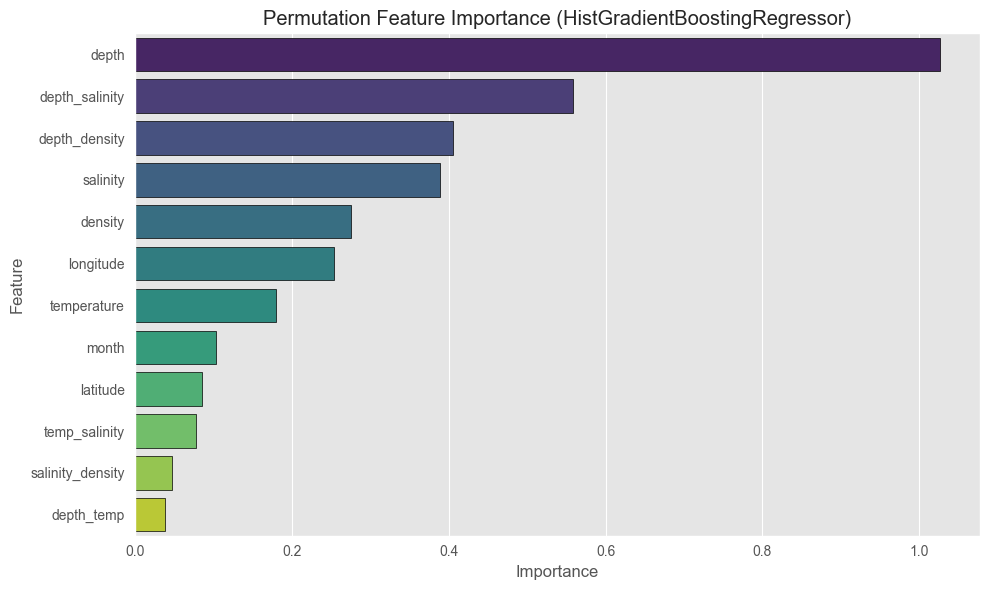

In [52]:
# Calculate permutation importance
result = permutation_importance(final_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Organize results
perm_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=perm_df, x='Importance', y='Feature', palette='viridis', edgecolor='k')
plt.title("Permutation Feature Importance (HistGradientBoostingRegressor)")
plt.tight_layout()
plt.show()

The permutation feature importance results reveal that oxygen concentration discrepancies between glider and ship-based measurements are not random, but are systematically influenced by environmental and oceanographic conditions. **Depth** acts as the most important variable, aligning with earlier observations that oxygen discrepancy tends to converge to 0 with increasing depth. Key interaction terms such as **depth × salinity** and **depth × density** highlight the importance of stratification in explaining sensor discrepancies and indicates that physical layering in the water column affects how gliders record oxygen compared to ships. These findings support the conclusion that glider measurements diverge from ship-based measurements under specific conditions—particularly in shallower, and more stratified waters. While the model explains 73.68% of the variance in oxygen discrepancy, the primary aim is not to achieve perfect prediction, but to demonstrate that oxygen discrepancy is driven by measurable ocean conditions and is not solely a result of random noise or sensor limitations.

## Conclusion

 In conclusion, glider oxygen readings are reliable in stable conditions but glider sensors are more prone to drift in shallow, dynamic surface waters affected by weather, tides, and day-night cycles, while deeper waters yield greater alignment with ship measurements. Interaction terms like depth × salinity and depth × density revealed that stratified water masses play a critical role. Our predictive model, which explained 74% of the variance in glider–ship oxygen differences, confirms that drift is not simply due to sensor aging or calibration, but is systematically influenced by environmental factors and mission context. With this understanding, glider oxygen measurements can be adjusted to account for predictable sources of error, improving accuracy and data reliability.


In [23]:
test_df = combined_df.sample(1000)
